# Full Project



### Patient Readmission Prediction

This notebook implements a complete end-to-end machine learning pipeline to predict hospital readmissions 
for diabetic patients using the “diabetic_data.csv” dataset. It covers:

1. **Data Loading & Exploration**  
   - Inspect dataset dimensions, sample-to-feature ratio  
   - Identify numerical, categorical, and binary features  
   - Analyze target distribution and simplify to a binary readmission label  

2. **Preprocessing & Feature Engineering**  
   - Handle missing and anomalous values (e.g. “?”, infrequent codes)  
   - Impute or drop features based on domain knowledge  
   - Encode categorical variables using frequency, target, and ordinal schemes  
   - Normalize numeric features via StandardScaler  
   - Balance the training set with oversampling  

3. **Model Selection & Hyperparameter Tuning**  
   - Compare SVM, Random Forest, and XGBoost classifiers  
   - Perform nested CV with GridSearchCV (for SVM) and RandomizedSearchCV  
   - Evaluate using F1-score, accuracy, precision, and recall  

4. **Feature Importance & Selection**  
   - Extract and visualize feature importances from each model  
   - Select top features based on importance thresholds and cumulative importance  
   - Retrain and compare performance before/after feature selection  

5. **Final Evaluation**  
   - Cross-validate the best model on selected features  
   - Report hold-out test metrics and discuss business implications  

**Usage:**  
- Ensure `diabetic_data.csv` is in the working directory  
- Install required packages: `pandas, numpy, scikit-learn, xgboost, imblearn, matplotlib, seaborn`  
- Run cells sequentially for data prep, modeling, and evaluation  


## Loading Data

In [89]:
# @title
!rm -rf .git
!git init
!git remote add origin https://github.com/dionferns/Applied-Artificial-Intelligence-Project.git
!git config core.sparseCheckout true
!echo "Dataset" > .git/info/sparse-checkout

!git pull origin main

# Move all files from the folder to the current directory (content)
!mv Dataset/* ./  # Move only the files inside the folder
!rm -rf Dataset   # Remove the original folder
!ls

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 9 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (9/9), 3.03 MiB | 2.32 MiB/s, done.
From https://github.com/dionferns/Applied-Artificial-Intelligence-Project
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
categorical_features_summary.csv  nume

In [90]:
import numpy as np
import pandas as pd

In [91]:
df = pd.read_csv("diabetic_data.csv")

## Task 1

### Data Size and Dimension

In [92]:
print(f"The sample-to-feature ratio is: {(df.shape[0] / df.shape[1])}")

The sample-to-feature ratio is: 2035.32


### Data types analysis

#### Numerical Features.

In [93]:
num_features = ['time_in_hospital', 'num_lab_procedures', 'num_lab_procedures','num_medications',
                 'number_outpatient', 'number_emergency', 'number_inpatient',
                 'number_diagnoses']
print(f"The numerical features are: {num_features}")


The numerical features are: ['time_in_hospital', 'num_lab_procedures', 'num_lab_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


#### Categorical features

In [94]:
cat_features = ['race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3','max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

print(f"The cateforical features are: {cat_features}")

The cateforical features are: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


#### Binary features

In [95]:
binary_features = list()
for col in cat_features:
    dion = df[col].value_counts(dropna=False).index
    if len(dion) <= 2:
        binary_features.append(col)
print(f"The binary features are: {binary_features}")

The binary features are: ['acetohexamide', 'tolbutamide', 'troglitazone', 'examide', 'citoglipton', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


### Target Variable analysis

Original class distribution:
Class 'NO': 54864 samples (53.91%)
Class '>30': 35545 samples (34.93%)
Class '<30': 11357 samples (11.16%)


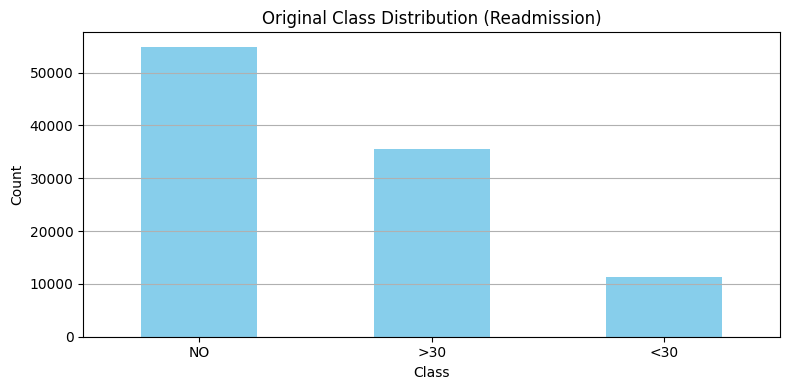


Simplified binary class distribution (Readmitted vs. Not readmitted):
Not readmitted (0): 54864 samples (53.91%)
Readmitted (1): 46902 samples (46.09%)


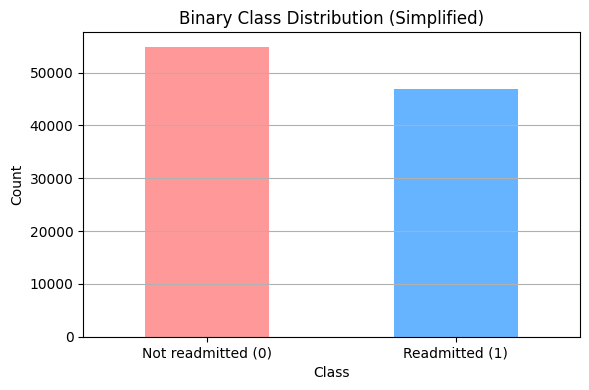

In [96]:
import matplotlib.pyplot as plt

# Original class distribution
original_counts = df['readmitted'].value_counts(dropna=False)
original_percentages = df['readmitted'].value_counts(normalize=True, dropna=False) * 100

print("Original class distribution:")
for cls, count in original_counts.items():
    print(f"Class '{cls}': {count} samples ({original_percentages[cls]:.2f}%)")

# Plot original distribution
plt.figure(figsize=(8, 4))
original_counts.plot(kind='bar', color='skyblue')
plt.title('Original Class Distribution (Readmission)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Simplified Binary Task
mapping = {">30": 1, "<30": 1, "NO": 0}
df_copy = df.copy()
df_copy['readmitted'] = df_copy['readmitted'].map(mapping)

# Binary class distribution
binary_counts = df_copy['readmitted'].value_counts(dropna=False)
binary_percentages = df_copy['readmitted'].value_counts(normalize=True, dropna=False) * 100

print("\nSimplified binary class distribution (Readmitted vs. Not readmitted):")
for cls, count in binary_counts.items():
    label = 'Readmitted' if cls == 1 else 'Not readmitted'
    print(f"{label} ({cls}): {count} samples ({binary_percentages[cls]:.2f}%)")

# Plot binary distribution
plt.figure(figsize=(6, 4))
binary_counts.plot(kind='bar', color=['#ff9999','#66b3ff'])
plt.title('Binary Class Distribution (Simplified)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Not readmitted (0)', 'Readmitted (1)'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Task 1 continuation + Task 2 Preprocessing

### Splitting the data

In [97]:
df_process = df.copy()

In [98]:
from sklearn.model_selection import train_test_split


X = df_process.drop(columns=['readmitted'])
y = df_process[['readmitted']]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [99]:
mapping = {">30": 1, "<30": 1, "NO": 0}

# Apply mapping to the correct column in y_train and y_test
if y_train['readmitted'].dtype == 'object':
    y_train['readmitted'] = y_train['readmitted'].map(mapping)
    y_test['readmitted'] = y_test['readmitted'].map(mapping)


### NaN conversion


In [100]:
# analysing admission_source_id:

before_process = df["admission_source_id"].value_counts(dropna=False)
print("Before pre-processing:")
print(before_process)
print()
print()
value = df["admission_source_id"].isin([9,15,17,20,21]).sum()
print(f"Number of values that should be converted to NaN: {value}")

print()
print()
X_train['admission_source_id'] = X_train['admission_source_id'].replace([9,15,17,20,21], np.nan)
X_test['admission_source_id'] = X_test['admission_source_id'].replace([9,15,17,20,21], np.nan)

value1 = df_process['admission_source_id'].isna().sum()
print(f"Number of values converted to NaN after processing: {value1}")
print()
print()
print("Value count after pre-process:")
print(X_train['admission_source_id'].value_counts(dropna=False))

Before pre-processing:
admission_source_id
7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
14        2
11        2
25        2
13        1
Name: count, dtype: int64


Number of values that should be converted to NaN: 7067


Number of values converted to NaN after processing: 0


Value count after pre-process:
admission_source_id
7.0     45990
1.0     23644
NaN      5643
4.0      2578
6.0      1823
2.0       881
5.0       674
3.0       143
8.0        14
22.0       11
10.0        4
11.0        2
25.0        2
14.0        2
13.0        1
Name: count, dtype: int64


In [101]:

before_process = df["discharge_disposition_id"].value_counts(dropna=False)
print("Before pre-processing:")
print(before_process)
print()
print()
value = df["discharge_disposition_id"].isin([18,25,26]).sum()
print(f"Number of values that should be converted to NaN: {value}")

print()
print()
X_train['discharge_disposition_id'] = X_train['discharge_disposition_id'].replace([18,25,26], np.nan)
X_test['discharge_disposition_id'] = X_test['discharge_disposition_id'].replace([18,25,26], np.nan)

value1 = df_process['discharge_disposition_id'].isna().sum()
print(f"Number of values converted to NaN after processing: {value1}")
print()
print()
print("Value count after pre-process:")
print(df_process['discharge_disposition_id'].value_counts(dropna=False))


Before pre-processing:
discharge_disposition_id
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: count, dtype: int64


Number of values that should be converted to NaN: 4680


Number of values converted to NaN after processing: 0


Value count after pre-process:
discharge_disposition_id
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: count, dtype: int64


In [102]:
print((df['diag_1'] == "?").sum() )
print((df['diag_2'] == "?").sum() )
print((df['diag_3'] == "?").sum() )
print()
print((X_train['diag_1'] == "?").sum() )
print((X_train['diag_2'] == "?").sum() )
print((X_train['diag_3'] == "?").sum() )
print()
print((X_test['diag_1'] == "?").sum() )
print((X_test['diag_2'] == "?").sum() )
print((X_test['diag_3'] == "?").sum() )
print()

X_train['diag_1'] = X_train['diag_1'].replace(["?"], np.nan)
X_train['diag_2'] = X_train['diag_2'].replace(["?"], np.nan)
X_train['diag_3'] = X_train['diag_3'].replace(["?"], np.nan)
print()
X_test['diag_1'] = X_test['diag_1'].replace(["?"], np.nan)
X_test['diag_2'] = X_test['diag_2'].replace(["?"], np.nan)
X_test['diag_3'] = X_test['diag_3'].replace(["?"], np.nan)

print()

print((X_train['diag_1'] == "?").sum() )
print((X_train['diag_2'] == "?").sum() )
print((X_train['diag_3'] == "?").sum() )
print()


print((X_test['diag_1'] == "?").sum() )
print((X_test['diag_2'] == "?").sum() )
print((X_test['diag_3'] == "?").sum() )


21
358
1423

17
271
1131

4
87
292



0
0
0

0
0
0


In [103]:
before_process = df["admission_type_id"].value_counts(dropna=False)
print("Before pre-processing:")
print(before_process)
print()
print()
value = df["admission_type_id"].isin([5,6, 8]).sum()
print(f"Number of values that should be converted to NaN: {value}")

print()
print()
X_train['admission_type_id'] = X_train['admission_type_id'].replace([5,6, 8], np.nan)
X_test['admission_type_id'] = X_test['admission_type_id'].replace([5,6, 8], np.nan)
value1 = df_process['admission_type_id'].isna().sum()
print(f"Number of values converted to NaN after processing: {value1}")
print()
print()
print("Value count after pre-process:")
print(df_process['admission_type_id'].value_counts(dropna=False))

Before pre-processing:
admission_type_id
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: count, dtype: int64


Number of values that should be converted to NaN: 10396


Number of values converted to NaN after processing: 0


Value count after pre-process:
admission_type_id
1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: count, dtype: int64


In [104]:

X_train['payer_code'].value_counts(dropna=False)
X_test['payer_code'].value_counts(dropna=False)
print()

X_train['payer_code'] = X_train['payer_code'].replace(["?"],np.nan)
X_test['payer_code'] = X_test['payer_code'].replace(["?"],np.nan)
print()

X_train['payer_code'].value_counts(dropna=False)
X_test['payer_code'].value_counts(dropna=False)

,count
payer_code,
NaN,8121
MC,6520
HM,1180
SP,1029
BC,933
MD,666
UN,498
CP,485
CM,386


In [105]:
X_train['weight'] = X_train['weight'].replace(["?"],np.nan)
X_test['weight'] = X_test['weight'].replace(["?"],np.nan)

In [106]:
print((df['medical_specialty'] == "?").sum() )
print((df['medical_specialty'] == "?").sum() )
print((df['medical_specialty'] == "?").sum() )
print()
print(X_train['medical_specialty'].value_counts(dropna=False))
print(X_test['medical_specialty'].value_counts(dropna=False))
print()

X_train['medical_specialty'] = X_train['medical_specialty'].replace(["?"],np.nan)
X_test['medical_specialty'] = X_test['medical_specialty'].replace(["?"],np.nan)
print()

print(X_train['medical_specialty'].value_counts(dropna=False))
print(X_test['medical_specialty'].value_counts(dropna=False))


49949
49949
49949

medical_specialty
?                         39969
InternalMedicine          11737
Emergency/Trauma           6043
Family/GeneralPractice     5912
Cardiology                 4283
                          ...  
SportsMedicine                1
Psychiatry-Addictive          1
Proctology                    1
Dermatology                   1
Neurophysiology               1
Name: count, Length: 72, dtype: int64
medical_specialty
?                                  9980
InternalMedicine                   2898
Family/GeneralPractice             1528
Emergency/Trauma                   1522
Cardiology                         1069
                                   ... 
Pediatrics-AllergyandImmunology       1
Endocrinology-Metabolism              1
Perinatology                          1
Pediatrics-Neurology                  1
Psychiatry-Child/Adolescent           1
Name: count, Length: 61, dtype: int64


medical_specialty
NaN                       39969
InternalMedicine         

In [107]:
print(X_train['gender'].value_counts(dropna=False))
print(X_test['gender'].value_counts(dropna=False))
print()
print(X_train['race'].value_counts(dropna=False))
print(X_test['race'].value_counts(dropna=False))
print()

# Replace "?" and "Unknown/Invalid" values with NaN
X_train['race'] = X_train['race'].replace(["?"], np.nan)
X_test['race'] = X_test['race'].replace(["?"], np.nan)
print()

X_train['gender'] = X_train['gender'].replace(["Unknown/Invalid"], np.nan)
X_test['gender'] = X_test['gender'].replace(["Unknown/Invalid"], np.nan)
print()

print(X_train['gender'].value_counts(dropna=False))
print(X_test['gender'].value_counts(dropna=False))

print()
print(X_train['race'].value_counts(dropna=False))
print(X_test['race'].value_counts(dropna=False))
print()



gender
Female             43740
Male               37670
Unknown/Invalid        2
Name: count, dtype: int64
gender
Female             10968
Male                9385
Unknown/Invalid        1
Name: count, dtype: int64

race
Caucasian          60871
AfricanAmerican    15325
?                   1824
Hispanic            1650
Other               1225
Asian                517
Name: count, dtype: int64
race
Caucasian          15228
AfricanAmerican     3885
?                    449
Hispanic             387
Other                281
Asian                124
Name: count, dtype: int64



gender
Female    43740
Male      37670
NaN           2
Name: count, dtype: int64
gender
Female    10968
Male       9385
NaN           1
Name: count, dtype: int64

race
Caucasian          60871
AfricanAmerican    15325
NaN                 1824
Hispanic            1650
Other               1225
Asian                517
Name: count, dtype: int64
race
Caucasian          15228
AfricanAmerican     3885
NaN                

### Part 1 visualisation after NaN conversion


#### Histograms (numerical features)

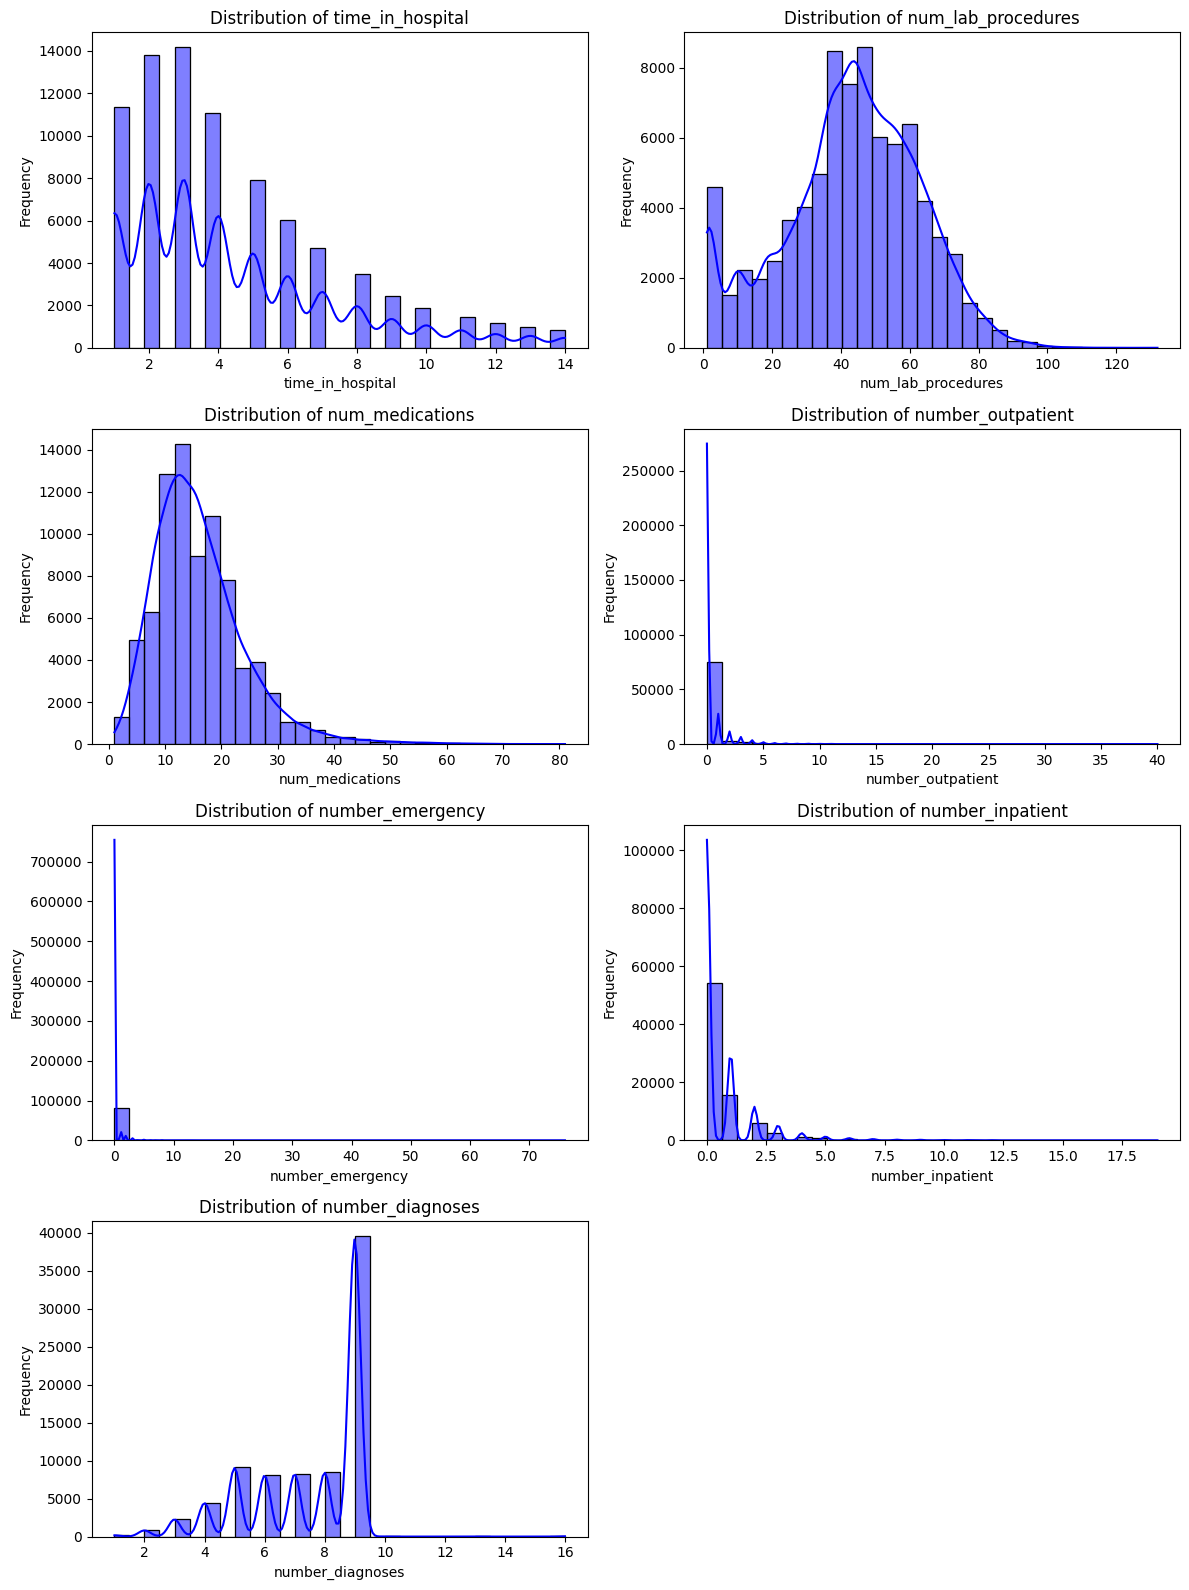

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt


cols_to_plot = ['time_in_hospital', 'num_lab_procedures', 'num_medications',
                'number_outpatient', 'number_emergency', 'number_inpatient',
                'number_diagnoses']

# Define the number of rows and columns dynamically based on the number of features
n_cols = 2  # Number of columns in the subplot
n_rows = (len(cols_to_plot) + n_cols - 1) // n_cols  # Dynamically calculate rows needed

# Create subplots dynamically
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 4))

# Flatten the 2D axes array for easier indexing
axes = axes.flatten()

# Loop through selected columns and plot
for idx, col in enumerate(cols_to_plot):
    sns.histplot(X_train[col], kde=True, bins=30, ax=axes[idx], color='blue')
    axes[idx].set_title(f"Distribution of {col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Frequency")

# Hide any empty subplots if cols_to_plot is less than n_rows * n_cols
for i in range(len(cols_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


#### Bar plots (categorical features)


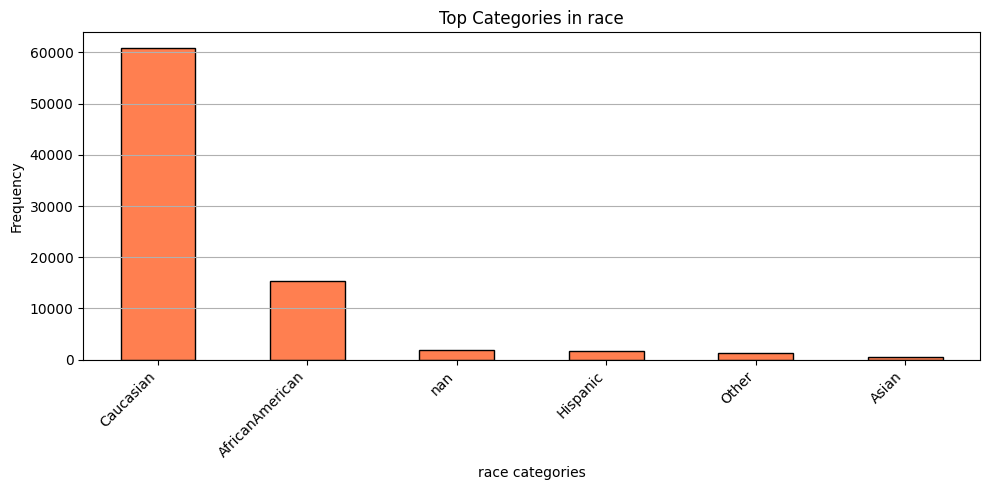

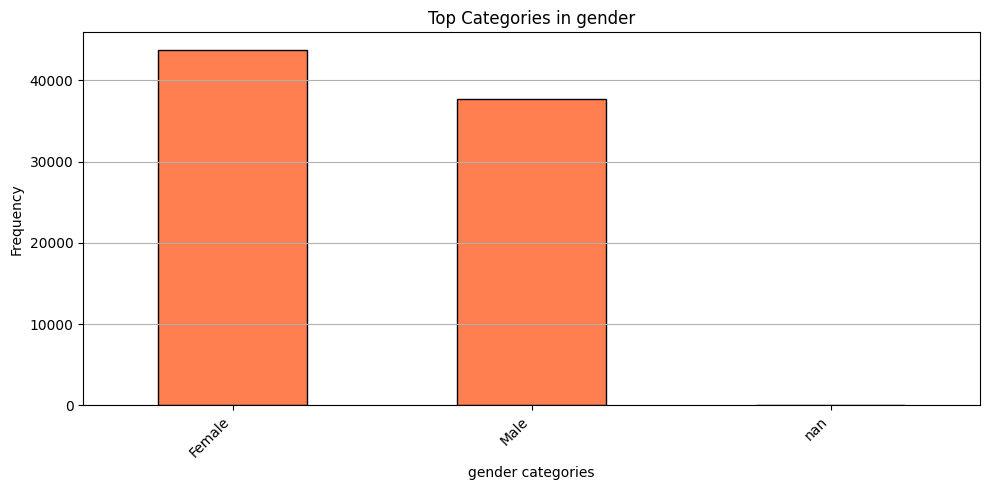

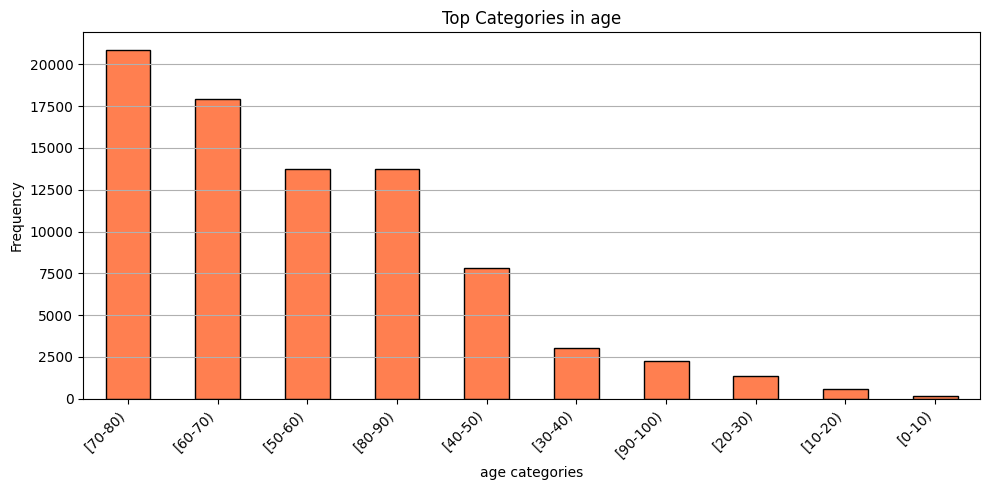

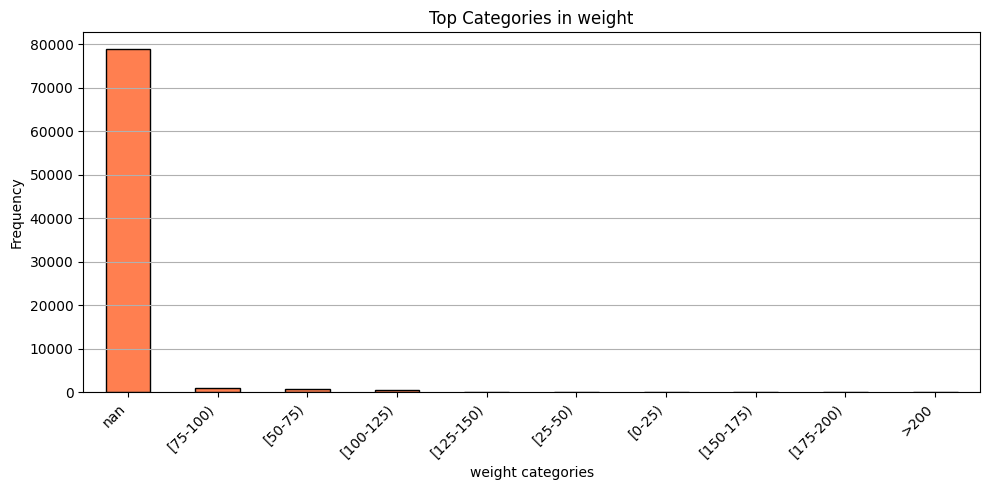

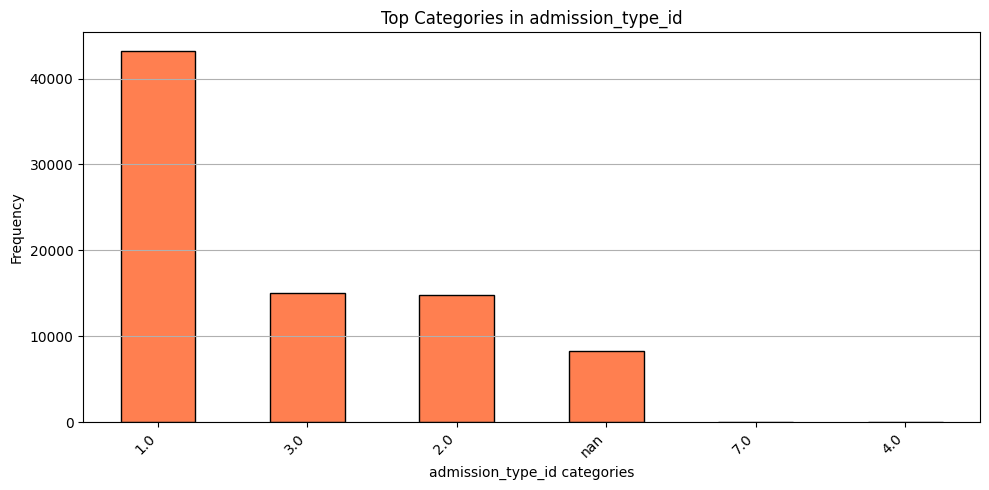

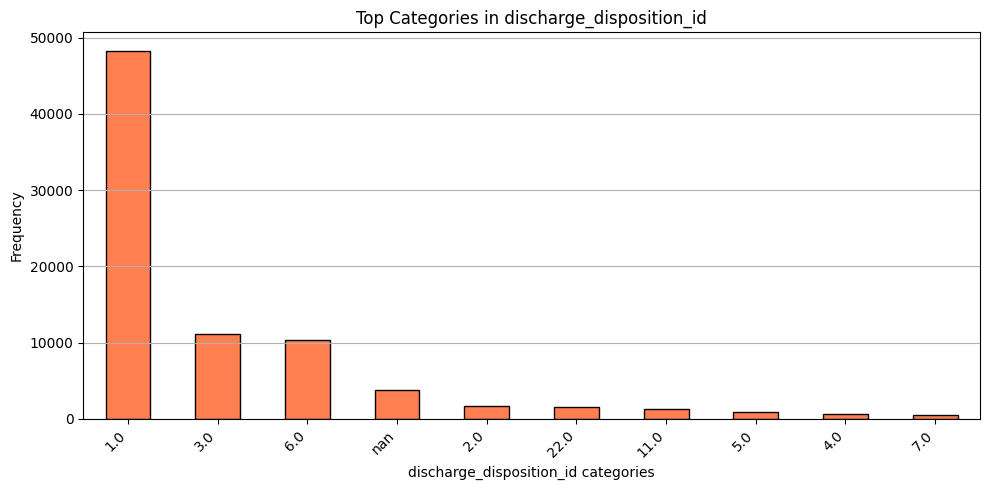

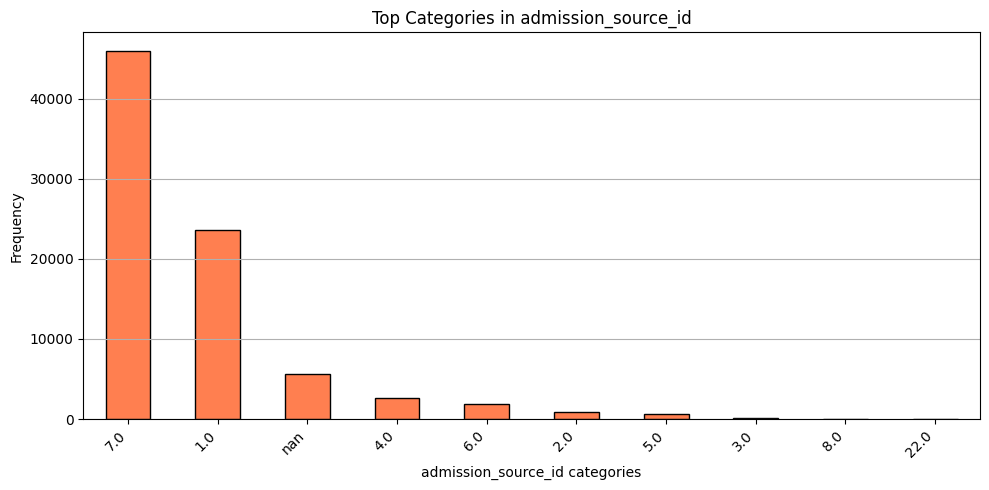

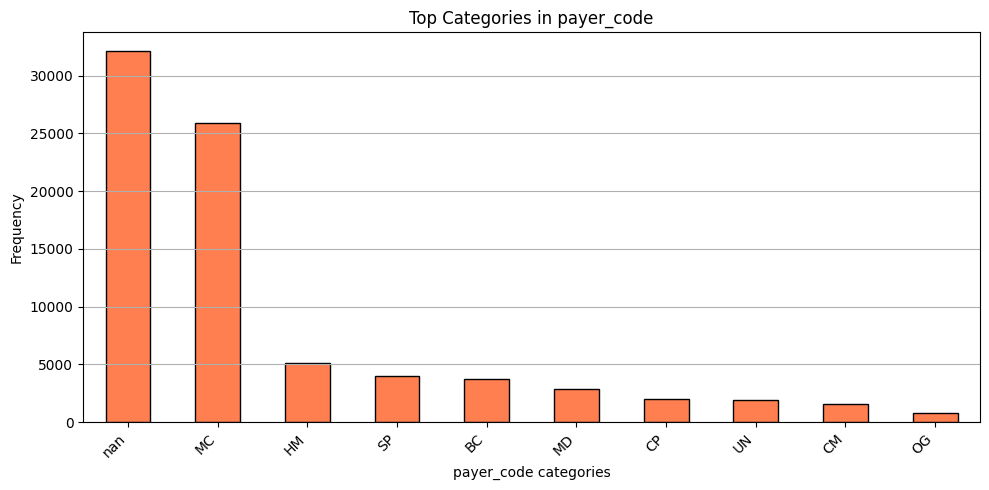

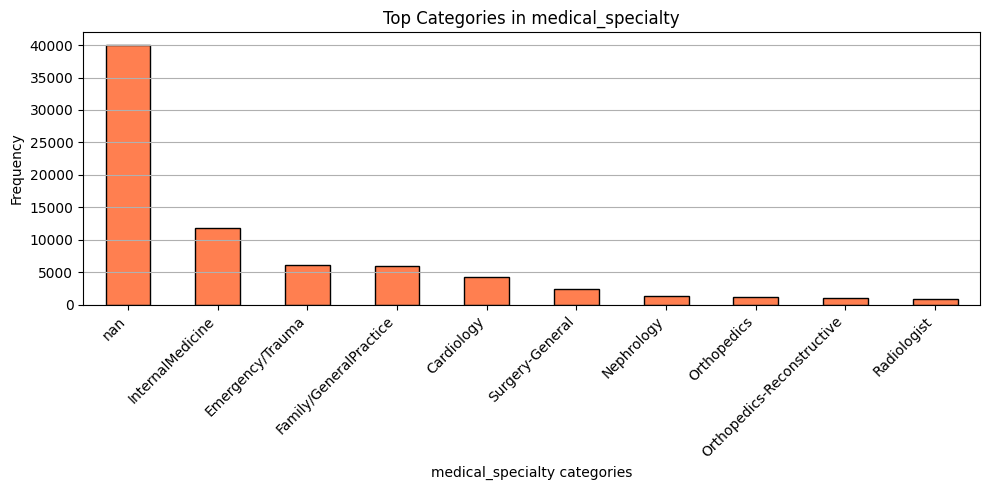

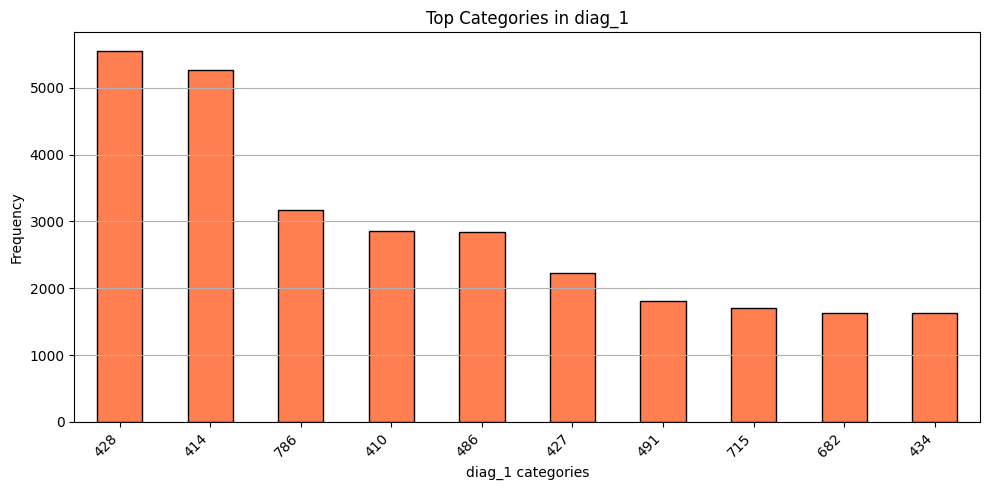

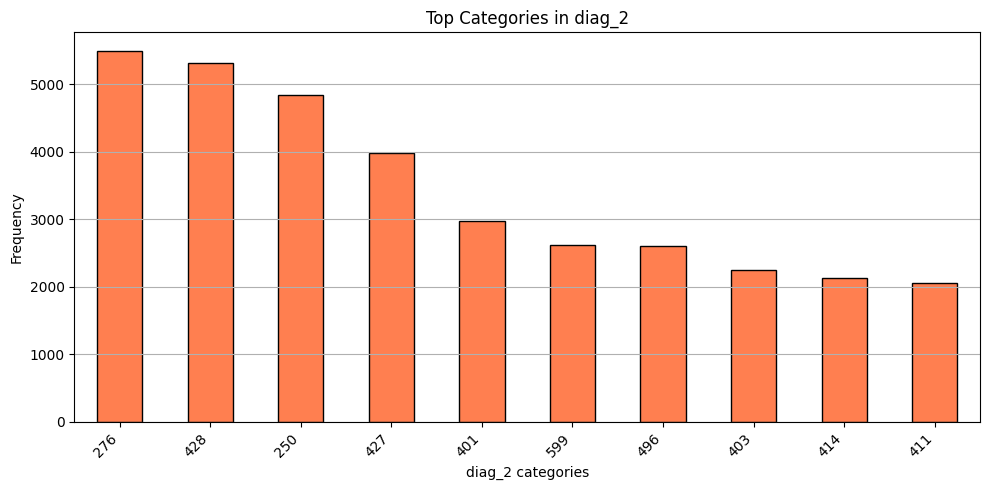

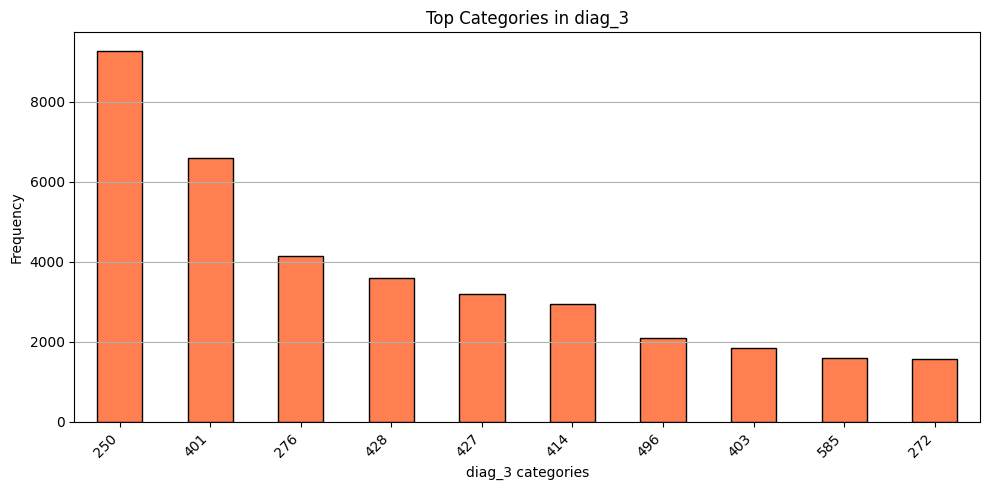

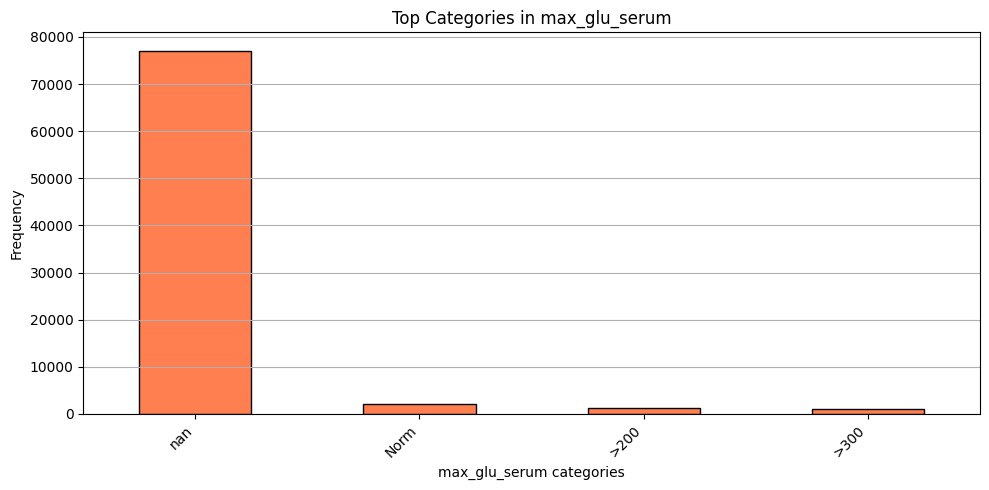

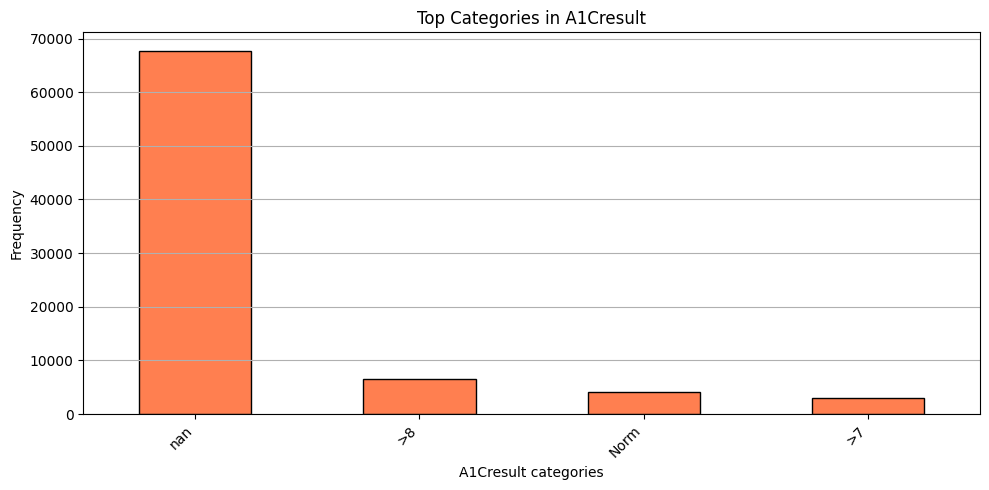

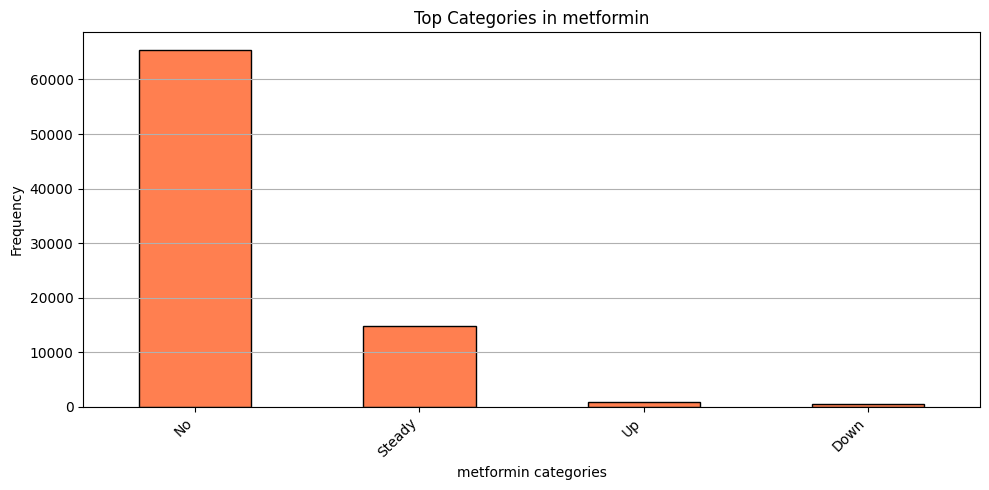

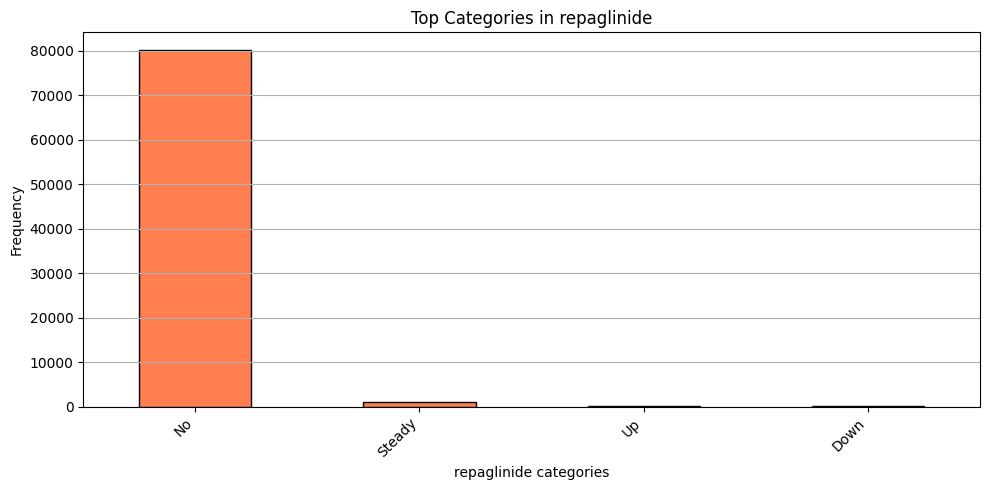

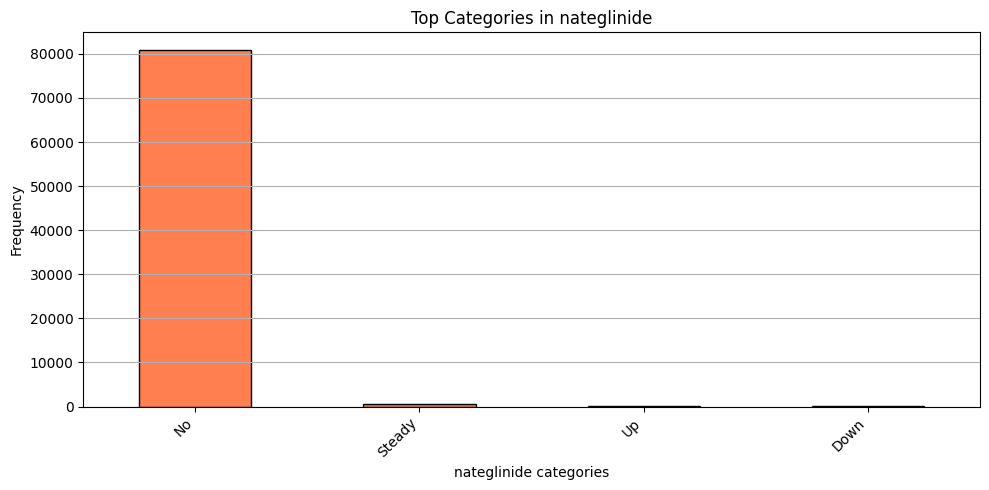

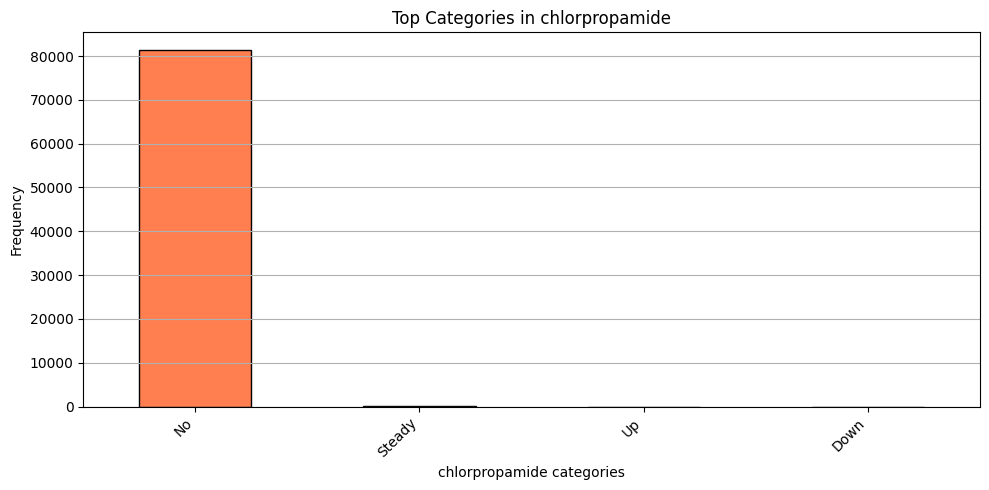

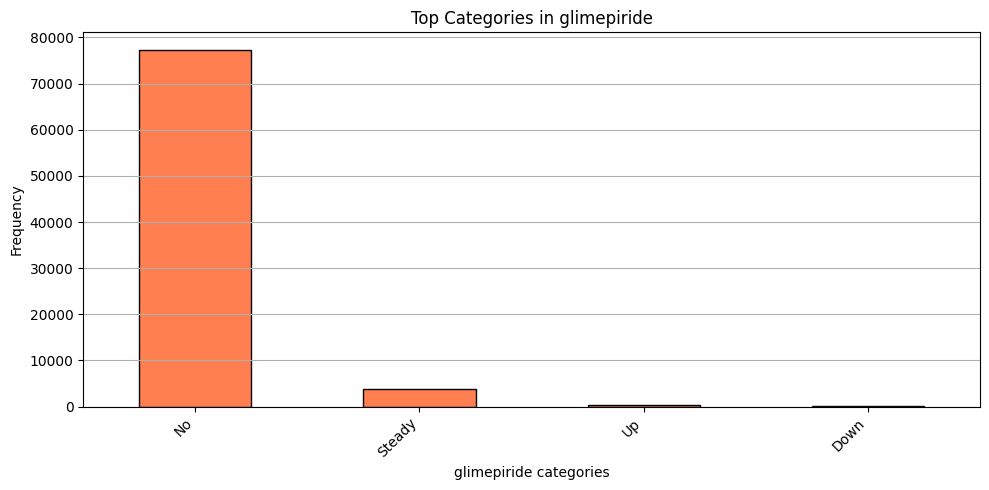

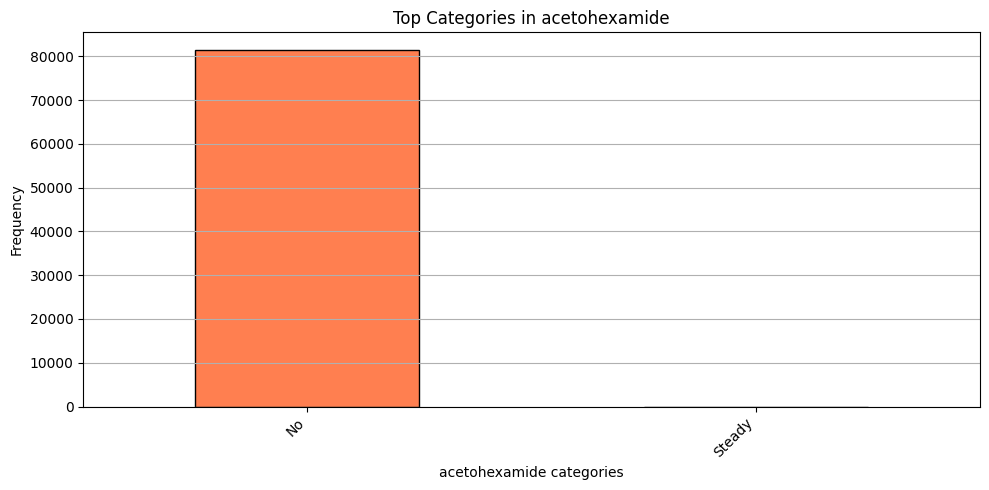

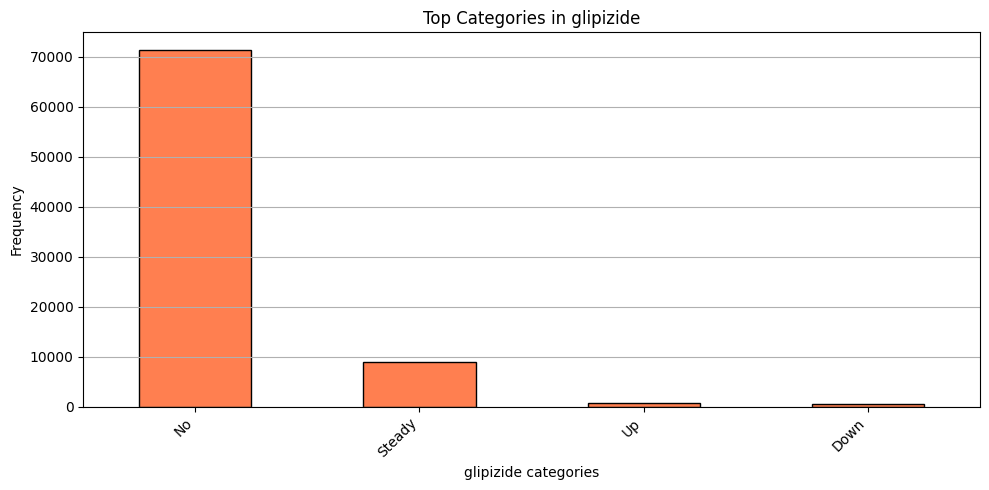

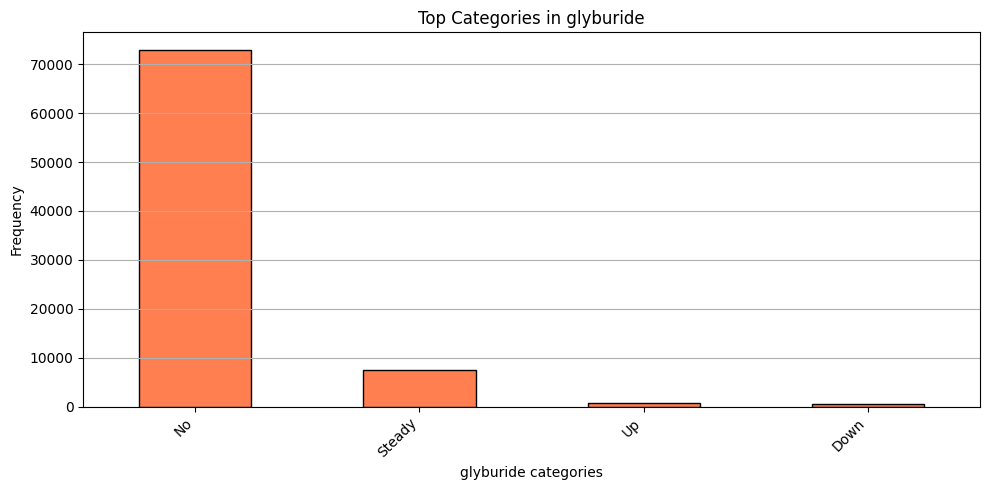

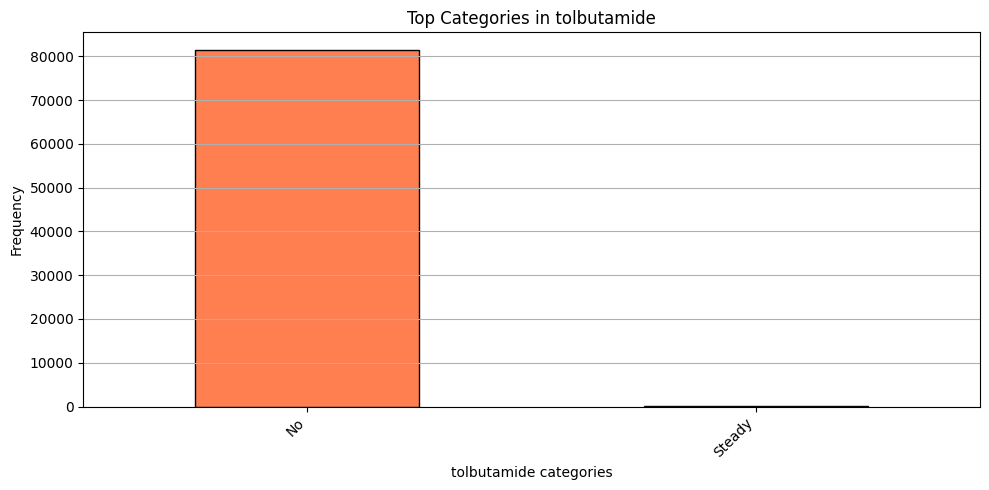

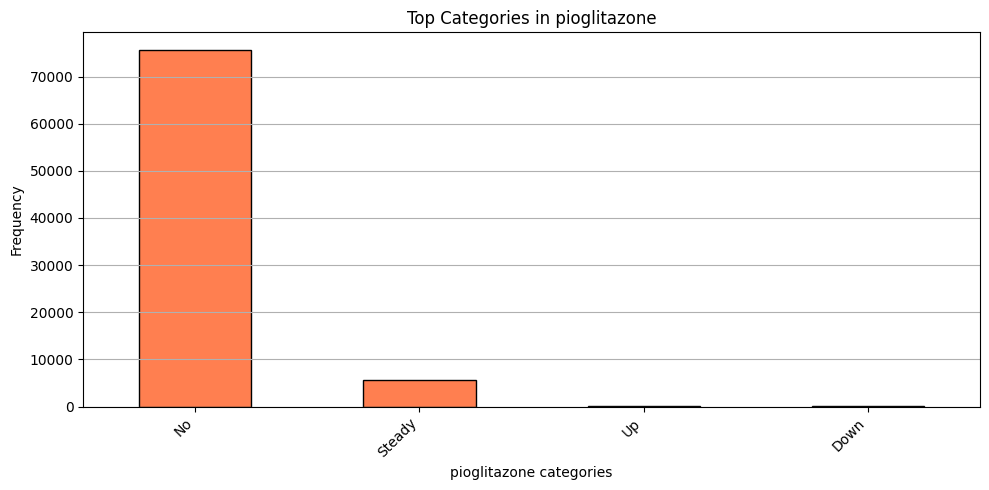

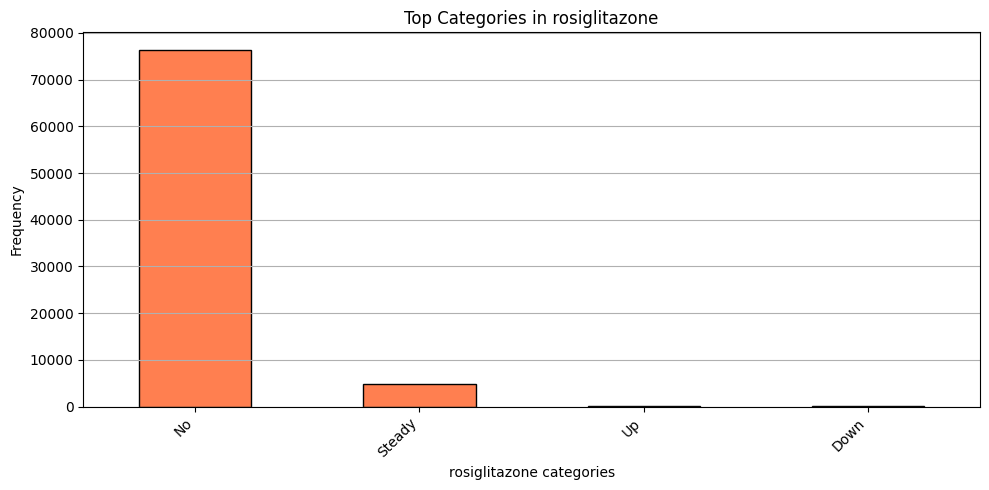

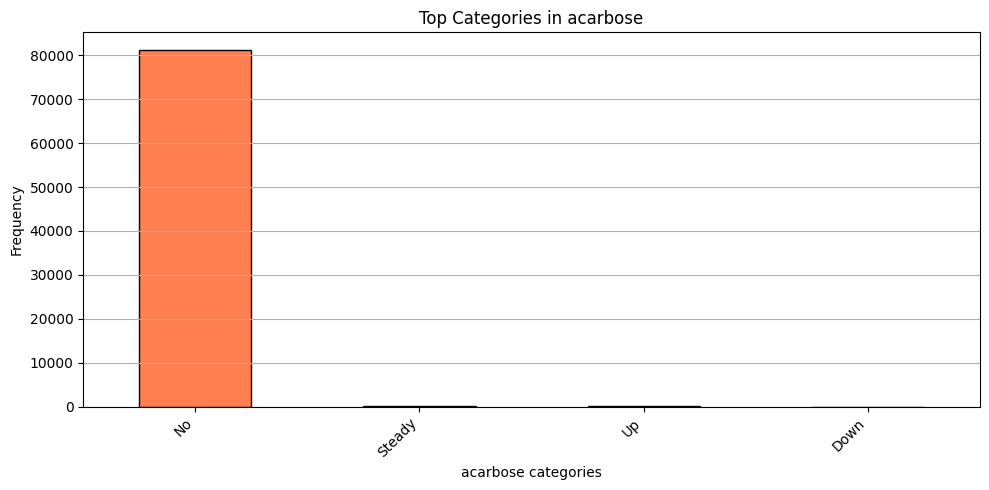

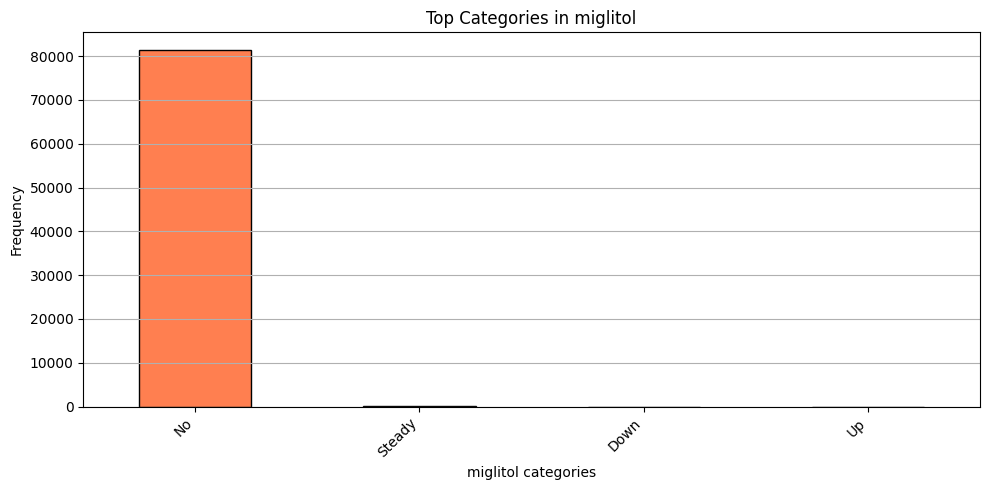

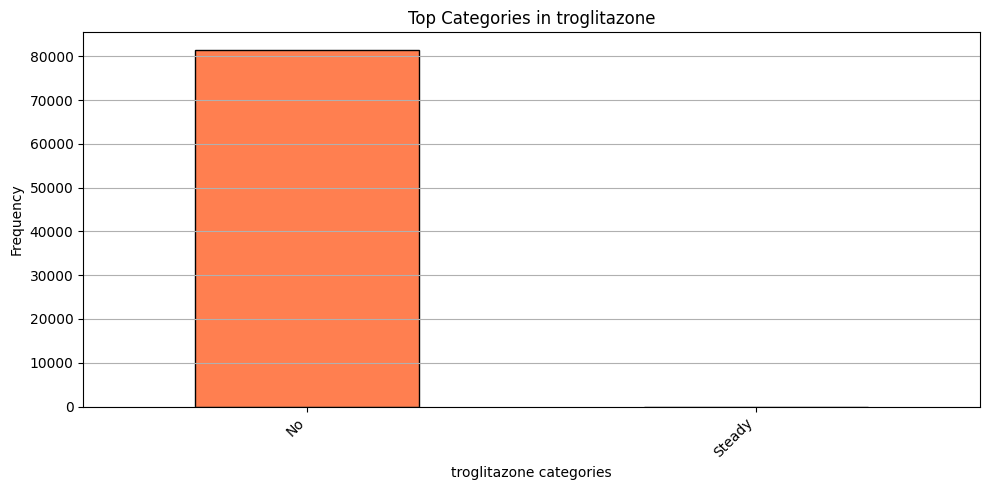

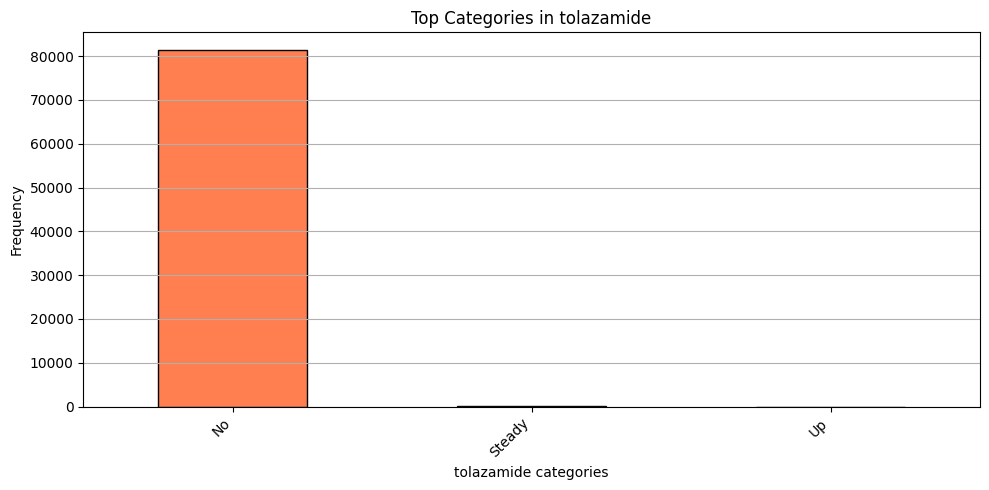

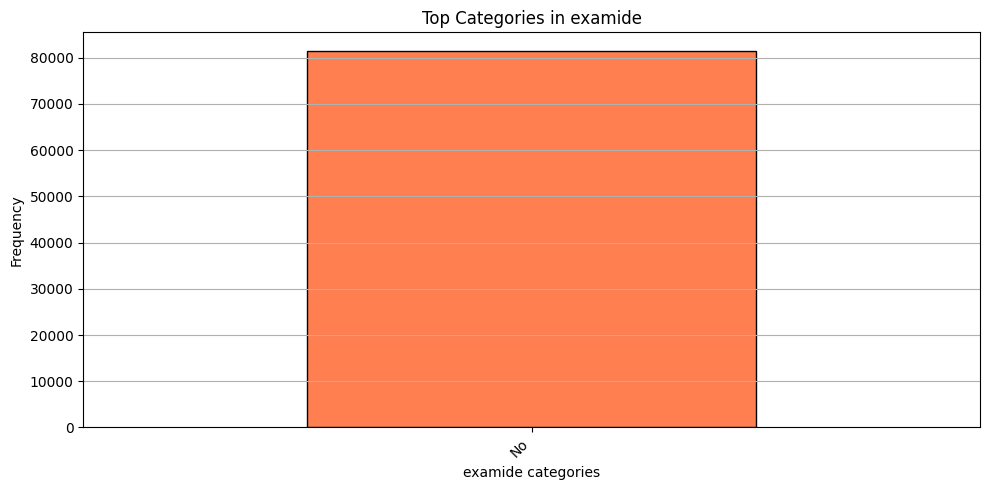

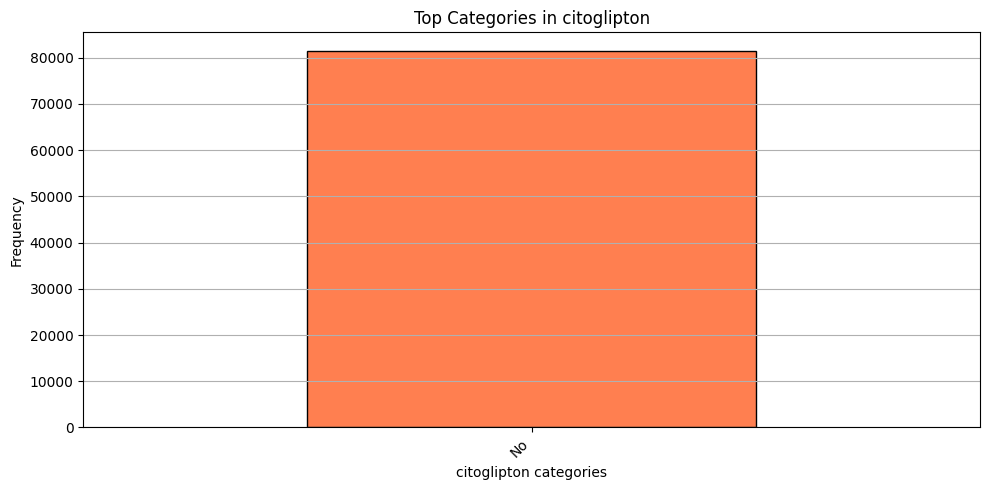

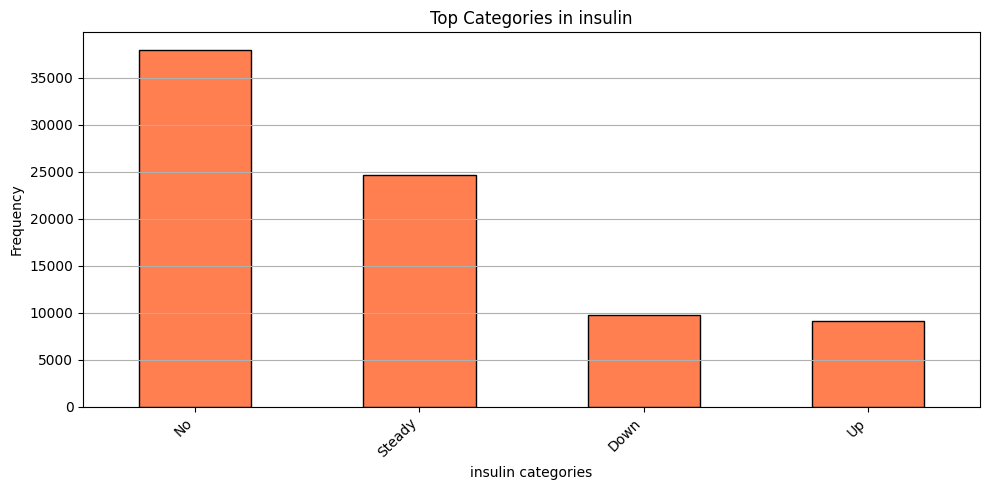

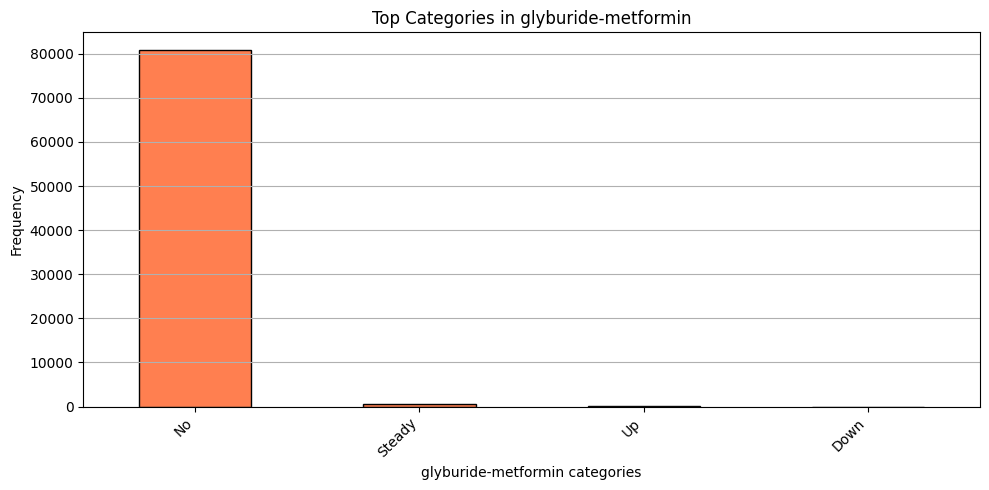

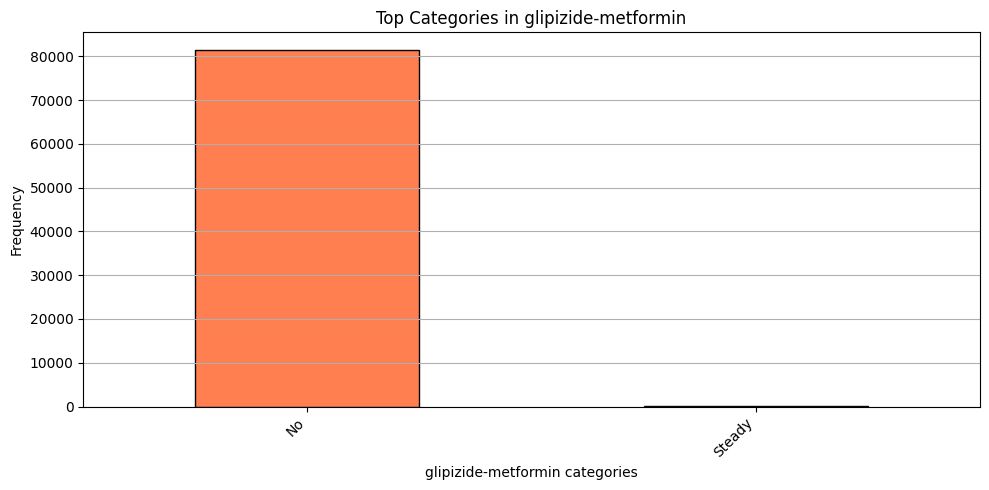

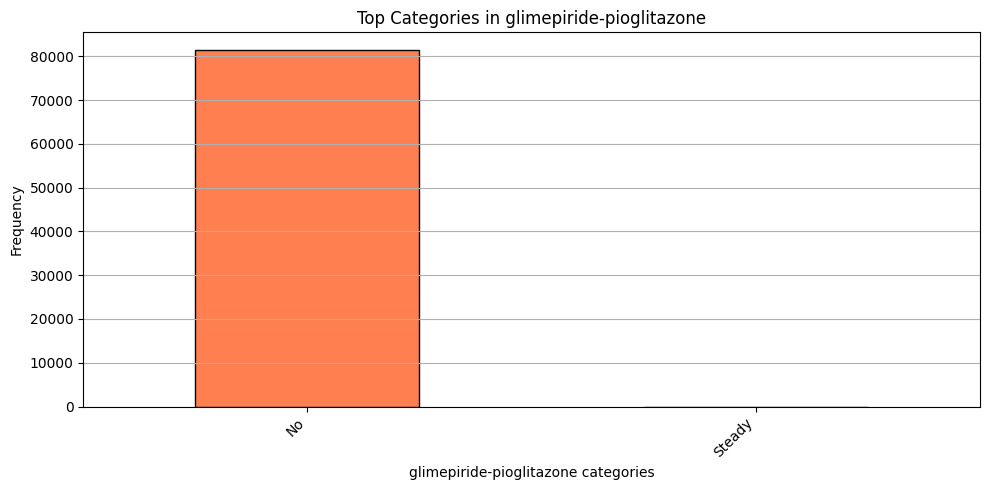

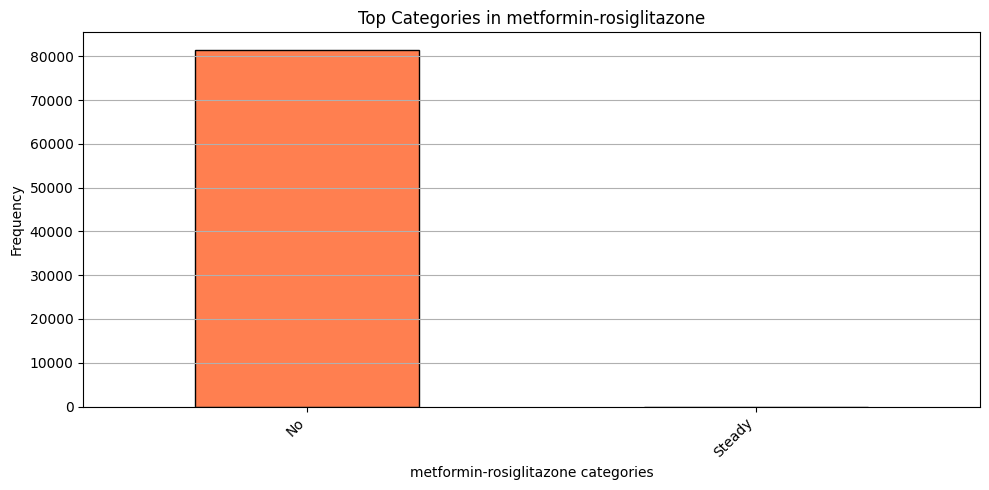

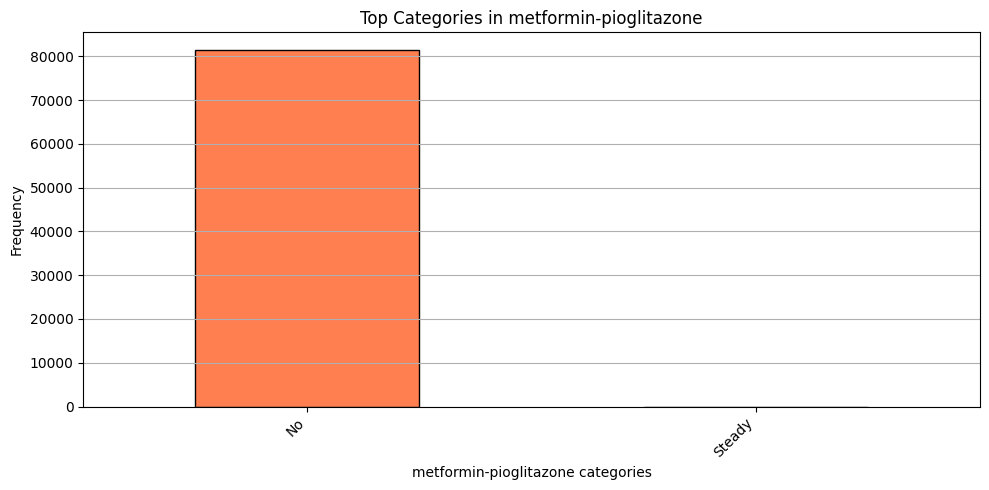

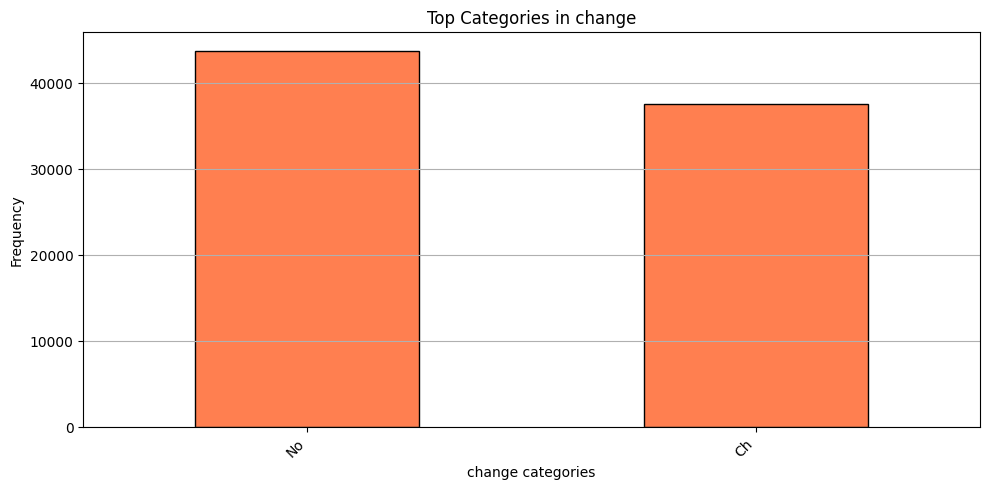

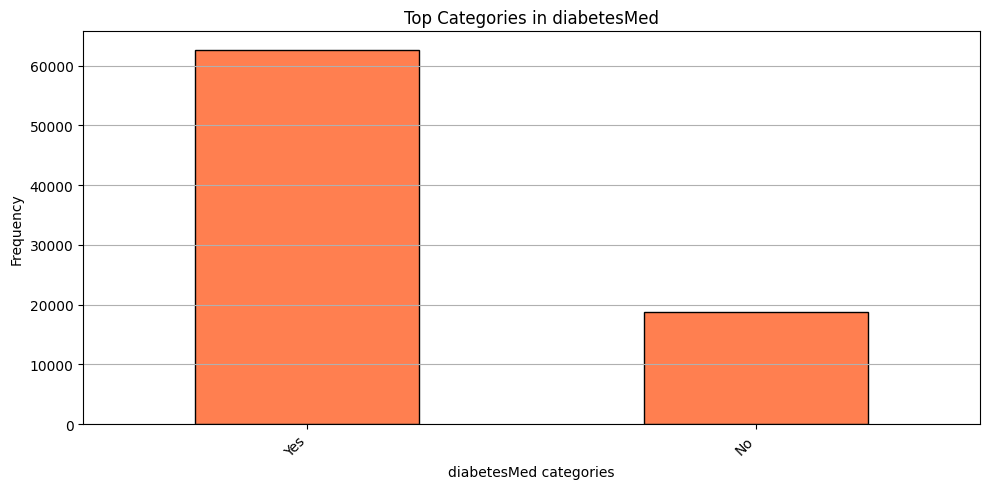

In [109]:

# cat_features = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
#                 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3',
#                  'metformin',  'glipizide', 'glyburide', 'pioglitazone',
#                 'rosiglitazone', 'insulin',
#                 'change', 'diabetesMed']
cat_features = ['race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
        'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3','max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']
# Categorical Feature Bar Plots (top 10 categories if too many)
for col in cat_features:
    plt.figure(figsize=(10, 5))
    top_categories = X_train[col].value_counts(dropna=False).nlargest(10)
    top_categories.plot(kind='bar', color='coral', edgecolor='black')
    plt.title(f'Top Categories in {col}')
    plt.xlabel(f'{col} categories')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

# Target variable (readmitted) distribution


if 'readmitted' in X_train.columns:
    plt.figure(figsize=(6, 4))
    readmit_counts = X_train['readmitted'].value_counts(dropna=False)
    readmit_counts.plot(kind='bar', color=['#66b3ff','#ff9999'], edgecolor='black')
    plt.title('Distribution of Target Variable (Readmitted)')
    plt.xlabel('Readmitted')
    plt.ylabel('Count')
    plt.xticks(ticks=[0,1], labels=['Not readmitted (0)', 'Readmitted (1)'], rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

#### Pie chart or bar plot (target distribution)


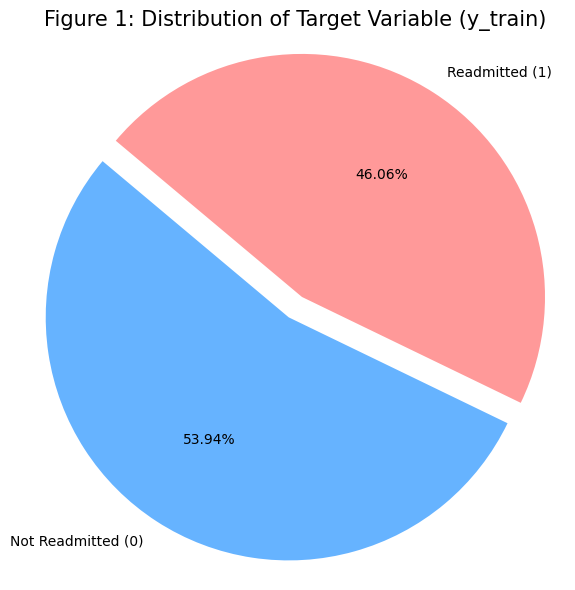

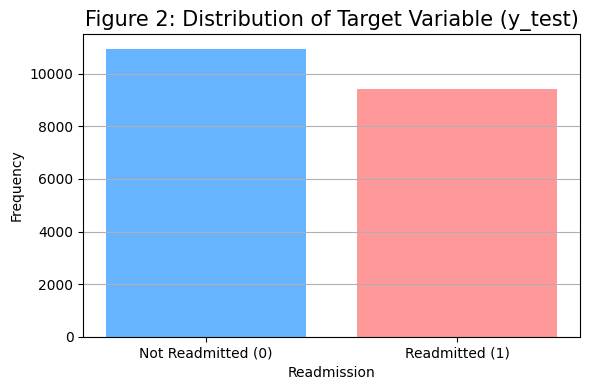

In [ ]:
import matplotlib.pyplot as plt


# import matplotlib.pyplot as plt

# Calculate distribution clearly
train_counts = y_train.value_counts().sort_index()
labels = ['Not Readmitted (0)', 'Readmitted (1)']
colors = ['#66b3ff', '#ff9999']

plt.figure(figsize=(6, 6))
plt.pie(train_counts, labels=labels, autopct='%1.2f%%', colors=colors,
        explode=[0.05,0.05], shadow=False, startangle=140)
plt.title('Figure 1: Distribution of Target Variable (y_train)', fontsize=15)
plt.axis('equal')  # For a neat circular pie chart
plt.tight_layout()
plt.show()


test_counts = y_test.value_counts()
test_labels = ['Not Readmitted (0)', 'Readmitted (1)']
plt.figure(figsize=(6, 4))
plt.bar(test_labels, test_counts, color=['#66b3ff','#ff9999'])
plt.title('Figure 2: Distribution of Target Variable (y_test)', fontsize=15)
plt.xlabel('Readmission')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### Missing Data


Missing Data in X_train:
                          Missing Values  Missing %
max_glu_serum                      77130  94.740333
A1Cresult                          67778  83.253083
medical_specialty                  39969  49.094728
payer_code                         32135  39.472068
admission_type_id                   8274  10.163121
admission_source_id                 5643   6.931411
discharge_disposition_id            3774   4.635680
race                                1824   2.240456
diag_3                              1131   1.389230
diag_2                               271   0.332875
diag_1                                17   0.020881
gender                                 2   0.002457

Missing Data in X_test:
                          Missing Values  Missing %
max_glu_serum                      19290  94.772526
A1Cresult                          16970  83.374275
medical_specialty                   9980  49.032131
payer_code                          8121  39.898791
admission_typ

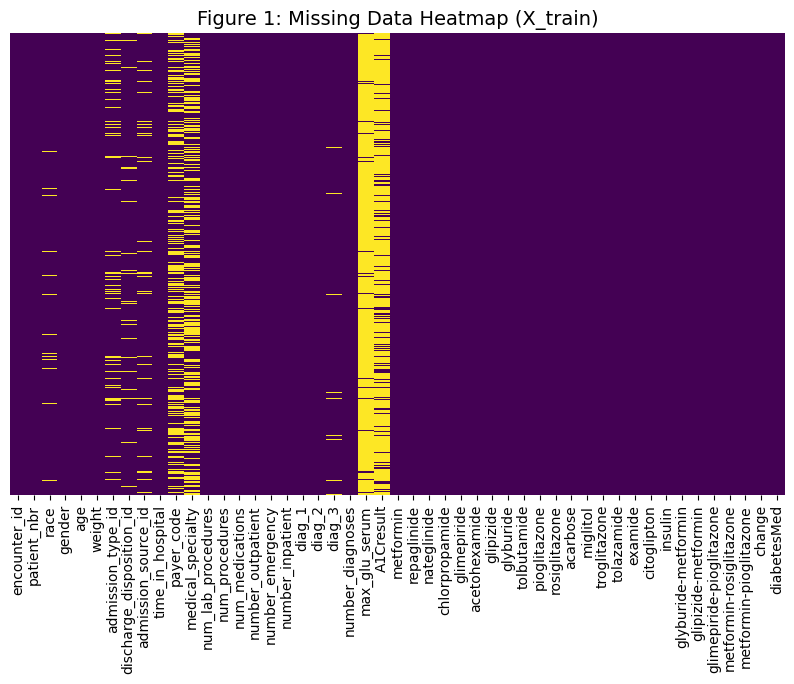

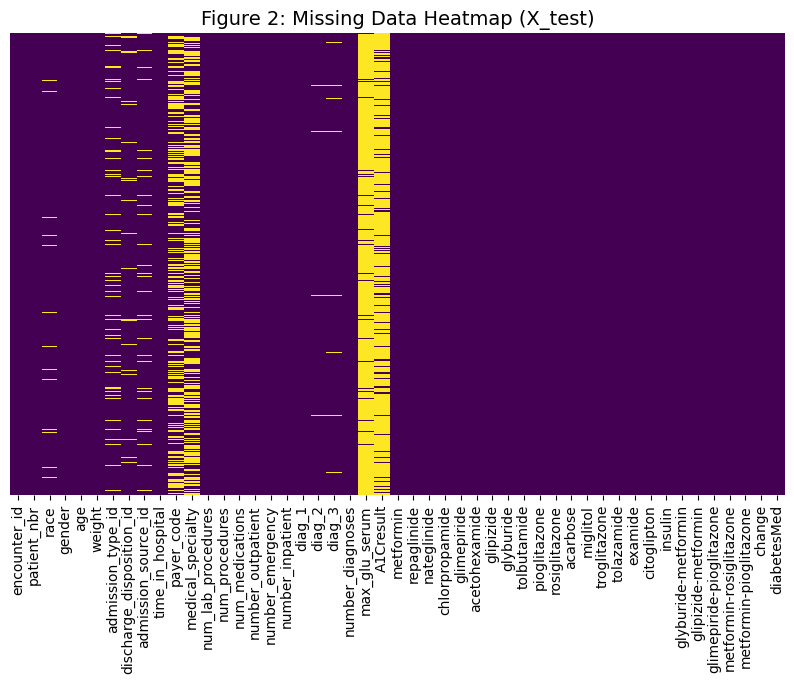

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute missing values in X_train
missing_train = X_train.isnull().sum()
missing_train_percent = (missing_train / len(X_train)) * 100
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)

# Compute missing values in X_test
missing_test = X_test.isnull().sum()
missing_test_percent = (missing_test / len(X_test)) * 100
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)

# Print results
print("\nMissing Data in X_train:")
print(pd.DataFrame({'Missing Values': missing_train, 'Missing %': missing_train_percent[missing_train.index]}))

print("\nMissing Data in X_test:")
print(pd.DataFrame({'Missing Values': missing_test, 'Missing %': missing_test_percent[missing_test.index]}))

#  Visualize Missing Data

plt.figure(figsize=(10, 6))
sns.heatmap(X_train.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Figure 1: Missing Data Heatmap (X_train)", fontsize=14)
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(X_test.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Figure 2: Missing Data Heatmap (X_test)", fontsize=14)
plt.show()


#### Class imbalance

Class Imbalance in y_train:
readmitted
0             43912
1             37500
Name: count, dtype: int64
readmitted
0             53.937994
1             46.062006
Name: count, dtype: float64


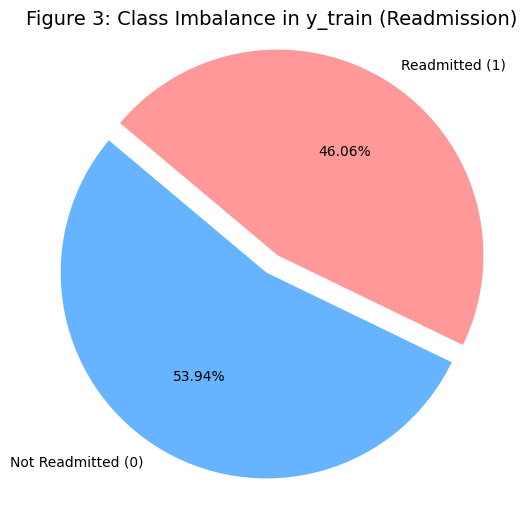

In [ ]:
# Compute class distribution
target_counts = y_train.value_counts()
target_percent = (target_counts / len(y_train)) * 100

# Print results
print("Class Imbalance in y_train:")
print(target_counts)
print(target_percent)

# Pie Chart for Class Distribution
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['Not Readmitted (0)', 'Readmitted (1)'],
        autopct='%1.2f%%', startangle=140, colors=['#66b3ff', '#ff9999'], explode=[0.05, 0.05])
plt.title('Figure 3: Class Imbalance in y_train (Readmission)', fontsize=14)
plt.axis('equal')
plt.show()


#### Categorical cardinality

In [ ]:
# Identify categorical features with high cardinality
high_cardinality_features = {col: X_train[col].nunique() for col in X_train.columns if X_train[col].dtype == 'object'}
high_cardinality_features = {k: v for k, v in high_cardinality_features.items() if v > 10}  # Threshold >10 categories

# Print features with many categories
print("\nCategorical Features with High Cardinality:")
for feature, count in high_cardinality_features.items():
    print(f"{feature}: {count} unique categories")



Categorical Features with High Cardinality:
payer_code: 17 unique categories
medical_specialty: 71 unique categories
diag_1: 691 unique categories
diag_2: 714 unique categories
diag_3: 761 unique categories


#### Redundant or Irrelevant Features

In [ ]:
 # Identify categorical features dominated by one category (e.g., >95% same value)
highly_imbalanced_cats = {col: X_train[col].value_counts(normalize=True).max() for col in X_train.columns if X_train[col].dtype == 'object'}
highly_imbalanced_cats = {k: v for k, v in highly_imbalanced_cats.items() if v > 0.95}

# Identify numerical features with very low variance
low_variance_nums = {col: X_train[col].var() for col in num_features if X_train[col].var() < 0.01}

# Print redundant features
print("\nHighly Imbalanced Categorical Features (likely redundant):")
for feature, prop in highly_imbalanced_cats.items():
    print(f"{feature}: {prop:.2f}% of data in one category")

print("\nNumerical Features with Very Low Variance (likely irrelevant):")
for feature, var in low_variance_nums.items():
    print(f"{feature}: Variance = {var:.5f}")


Highly Imbalanced Categorical Features (likely redundant):
weight: 0.97% of data in one category
repaglinide: 0.98% of data in one category
nateglinide: 0.99% of data in one category
chlorpropamide: 1.00% of data in one category
acetohexamide: 1.00% of data in one category
tolbutamide: 1.00% of data in one category
acarbose: 1.00% of data in one category
miglitol: 1.00% of data in one category
troglitazone: 1.00% of data in one category
tolazamide: 1.00% of data in one category
examide: 1.00% of data in one category
citoglipton: 1.00% of data in one category
glyburide-metformin: 0.99% of data in one category
glipizide-metformin: 1.00% of data in one category
glimepiride-pioglitazone: 1.00% of data in one category
metformin-rosiglitazone: 1.00% of data in one category
metformin-pioglitazone: 1.00% of data in one category

Numerical Features with Very Low Variance (likely irrelevant):


#### Summary Statistics

In [ ]:
import pandas as pd

# Numerical Features Descriptive Statistics
numerical_summary = X_train[num_features].describe().T
numerical_summary['missing_values'] = X_train[num_features].isnull().sum()
numerical_summary['missing_%'] = (numerical_summary['missing_values'] / len(X_train)) * 100

# Save Numerical Features Summary as CSV
numerical_csv_filename = "numerical_features_summary.csv"
numerical_summary.to_csv(numerical_csv_filename, index=True)

# Categorical Features Descriptive Statistics
categorical_summary = pd.DataFrame(columns=['Feature', 'Unique_values', 'Top_category',
                                            'Top_freq_%', 'Missing_values', 'Missing_%'])

for col in cat_features:
    unique_values = X_train[col].nunique(dropna=True)
    top_category = X_train[col].mode(dropna=True).iloc[0]
    top_freq = X_train[col].value_counts(dropna=True).iloc[0]
    top_freq_percent = (top_freq / len(X_train)) * 100  # Convert to percentage
    missing_values = X_train[col].isnull().sum()
    missing_percent = (missing_values / len(X_train)) * 100

    categorical_summary = pd.concat([categorical_summary, pd.DataFrame({
        'Feature': [col],
        'Unique_values': [unique_values],
        'Top_category': [top_category],
        'Top_freq_%': [top_freq_percent],  # Store as percentage
        'Missing_values': [missing_values],
        'Missing_%': [missing_percent]
    })], ignore_index=True)

# Save Categorical Features Summary as CSV
categorical_csv_filename = "categorical_features_summary.csv"
categorical_summary.to_csv(categorical_csv_filename, index=False)

print("CSV files saved successfully!")


<ipython-input-36-a55d7c1cca9f>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  categorical_summary = pd.concat([categorical_summary, pd.DataFrame({


CSV files saved successfully!


### dropping features

In [ ]:
# Dropping encounter_id
if 'encounter_id' in X_train.columns:
    X_train.drop(columns=['encounter_id'], inplace=True)
    X_test.drop(columns=['encounter_id'], inplace=True)

In [ ]:
if 'patient_nbr' in X_train.columns:
    X_train.drop(columns=['patient_nbr'], inplace=True)
    X_test.drop(columns=['patient_nbr'], inplace=True)

In [ ]:
# df['weight'].value_counts(dropna=False, normalize=True)*100
if 'max_glu_serum' in X_train.columns:
    X_train.drop(columns=['max_glu_serum' ,'A1Cresult', 'weight'], inplace=True)
    X_test.drop(columns=['max_glu_serum' ,'A1Cresult' , 'weight'], inplace=True)

In [ ]:
dropped_col = ['metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone',
         'glipizide-metformin', 'miglitol', 'examide','citoglipton',
         'acarbose','chlorpropamide', 'acetohexamide','tolbutamide','troglitazone', 'tolazamide',
         'repaglinide','nateglinide','glimepiride', 'glyburide-metformin']

if 'chlorpropamide' in X_train.columns:
    X_train.drop(columns=dropped_col, inplace=True)
    X_test.drop(columns=dropped_col, inplace=True)

## Task 2 Encoding

### Admission source id

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


from sklearn.impute import SimpleImputer

if 'admission_source_id' in X_train.columns:
    X_train[ 'admission_source_id'] = X_train['admission_source_id'].fillna("Missing")
    X_test['admission_source_id'] = X_test['admission_source_id'].fillna("Missing")

    # Reset index before KFold
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_train['payer_code_encoded'] = 0.0
    X_test['payer_code_encoded'] = 0.0

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    X_train['admission_source_encoded'] = 0.0

    for train_idx, val_idx in kf.split(X_train):
        train_fold, val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]

        # Compute frequency encoding for training fold
        freq_map = train_fold['admission_source_id'].value_counts(normalize=True).to_dict()
        mean_freq = np.mean(list(freq_map.values()))
        # Apply encoding to validation fold
        X_train.loc[val_idx, 'admission_source_encoded'] = val_fold['admission_source_id'].map(freq_map).fillna(mean_freq)

    # Compute final encoding for test set using full training set frequencies
    final_freq_map = X_train['admission_source_id'].value_counts(normalize=True).to_dict()
    X_test['admission_source_encoded'] = X_test['admission_source_id'].map(final_freq_map).fillna(X_train['admission_source_encoded'].mean())

    # Drop original categorical column
    X_train.drop(columns=['admission_source_id'], inplace=True)
    X_test.drop(columns=['admission_source_id'], inplace=True)

    scaler = StandardScaler()

    X_train[['admission_source_encoded']] = scaler.fit_transform(X_train[['admission_source_encoded']])
    X_test[['admission_source_encoded']] = scaler.transform(X_test[['admission_source_encoded']])

### discharge_disposition_id

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Reset index properly
# X_train = X_train.reset_index(drop=True)

if 'discharge_disposition_id' in X_train.columns:

    # Step 1: Handle Missing Values
    X_train['discharge_disposition_id'] = X_train['discharge_disposition_id'].fillna("Missing")
    X_test['discharge_disposition_id'] = X_test['discharge_disposition_id'].fillna("Missing")

    # imputer = SimpleImputer(strategy='median')
    # X_train['discharge_disposition_id'] = imputer.fit_transform(X_train[['discharge_disposition_id']])
    # X_test['discharge_disposition_id'] = imputer.transform(X_test[['discharge_disposition_id']])
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_train['payer_code_encoded'] = 0.0
    X_test['payer_code_encoded'] = 0.0

    # Step 2: Initialize K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    X_train['discharge_disposition_encoded'] = 0.0

    # Step 3: K-Fold Frequency Encoding (Avoid Data Leakage)
    for train_idx, val_idx in kf.split(X_train):
        train_fold, val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]

        # Compute frequency encoding for training fold
        freq_map = train_fold['discharge_disposition_id'].value_counts(normalize=True).to_dict()
        freq_mean = np.mean(list(freq_map.values()))
        # Apply encoding to validation fold
        X_train.loc[val_idx, 'discharge_disposition_encoded'] = val_fold['discharge_disposition_id'].map(freq_map).fillna(freq_mean)

    # Step 4: Compute Final Encoding for Test Set Using Full Training Data
    final_freq_map = X_train['discharge_disposition_id'].value_counts(normalize=True).to_dict()
    X_test['discharge_disposition_encoded'] = X_test['discharge_disposition_id'].map(final_freq_map).fillna(X_train['discharge_disposition_encoded'].mean())

    # Step 5: Drop the Original Column
    X_train.drop(columns=['discharge_disposition_id'], inplace=True)
    X_test.drop(columns=['discharge_disposition_id'], inplace=True)

    # Step 6: Ensure No Missing Values Before Standardization
    X_train['discharge_disposition_encoded'] = X_train['discharge_disposition_encoded'].fillna(0)
    X_test['discharge_disposition_encoded'] = X_test['discharge_disposition_encoded'].fillna(0)

    # Step 7: Standardize for SVM (Ensure correct reshaping)
    scaler = StandardScaler()
    X_train['discharge_disposition_encoded'] = scaler.fit_transform(X_train[['discharge_disposition_encoded']].values.reshape(-1, 1))
    X_test['discharge_disposition_encoded'] = scaler.transform(X_test[['discharge_disposition_encoded']].values.reshape(-1, 1))

# Display processed data
X_train.head(100)


,race,gender,age,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,glipizide,glyburide,pioglitazone,rosiglitazone,insulin,change,diabetesMed,payer_code_encoded,admission_source_encoded,discharge_disposition_encoded
0,Caucasian,Female,[70-80),1.0,4,NaN,InternalMedicine,48,0,11,...,No,No,No,No,No,No,No,0.0,0.804116,0.818623
1,Caucasian,Male,[50-60),1.0,1,BC,NaN,42,0,5,...,No,No,No,No,No,No,No,0.0,0.804116,0.818623
2,Caucasian,Male,[80-90),1.0,4,NaN,NaN,44,0,10,...,No,Steady,No,No,No,No,Yes,0.0,0.808422,0.816826
3,Caucasian,Male,[80-90),1.0,3,MC,NaN,54,0,8,...,No,Steady,No,No,Steady,Ch,Yes,0.0,0.804116,-1.022729
4,AfricanAmerican,Female,[70-80),1.0,11,MC,Nephrology,35,3,23,...,No,No,No,No,No,No,No,0.0,0.804959,-1.508380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Caucasian,Male,[50-60),2.0,5,CP,Family/GeneralPractice,65,1,23,...,No,No,No,No,Down,Ch,Yes,0.0,0.804959,0.823369
96,Caucasian,Female,[40-50),1.0,7,HM,NaN,36,4,25,...,No,No,Steady,No,No,Ch,Yes,0.0,0.804116,-1.063752
97,Caucasian,Female,[80-90),1.0,1,MD,NaN,55,0,13,...,No,No,No,No,Down,Ch,Yes,0.0,0.803718,-1.556035
98,Caucasian,Male,[50-60),NaN,3,NaN,InternalMedicine,56,0,8,...,No,No,No,No,No,No,No,0.0,0.802248,0.820457


### 'num_lab_procedures', 'num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient'

SVM is distance-based, meaning features with larger values can dominate smaller ones.
num_lab_procedures has 150 unique values, which could range widely.
StandardScaler() transforms the feature to have mean = 0 and standard deviation = 1, making it comparable to other features.

In [ ]:

col_list = ['num_lab_procedures', 'num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient' ]

In [ ]:
from sklearn.preprocessing import StandardScaler


if 'num_lab_procedures' in X_train.columns:
    scaler = StandardScaler()

    # Standardize Training Data
    X_train[col_list] = scaler.fit_transform(X_train[col_list])

    # Apply Same Scaling to Test Data
    X_test[col_list] = scaler.transform(X_test[col_list])

    X_train.head(8)


### diag_1, diag_2, diag_3

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Reset index properly
X_train = X_train.reset_index(drop=True)
# X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)


if 'diag_1' in X_train.columns:
    for diag in ['diag_1', 'diag_2', 'diag_3']:
        # Step 1: Handle Missing Values (Avoid Chained Assignment Warning)
        X_train[diag] = X_train[diag].fillna("Missing")
        X_test[diag] = X_test[diag].fillna("Missing")

        # Step 2: Initialize K-Fold
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        X_train[diag + '_encoded'] = 0.0  # Placeholder
        # X_test[diag + '_encoded'] = 0.0  # Placeholder


        # Step 3: K-Fold Frequency Encoding (Avoid Data Leakage)
        for train_idx, val_idx in kf.split(X_train):
            train_fold, val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]

            # Reset index to prevent misalignment issues
            # val_fold = val_fold.reset_index(drop=True)

            # Compute frequency encoding for training fold
            freq_map = train_fold[diag].value_counts(normalize=True).to_dict()
            freq_mean = np.mean(list(freq_map.values()))
            # Apply encoding to validation fold
            X_train.loc[val_idx, diag + '_encoded'] = val_fold[diag].map(freq_map).fillna(freq_mean)

        # Step 4: Compute Final Encoding for Test Set Using Full Training Data
        final_freq_map = X_train[diag].value_counts(normalize=True).to_dict()
        full_freq_mean = np.mean(list(final_freq_map.values()))
        smoothing_factor = 1e-6  # Small constant to avoid overestimating frequency
        X_test[diag + '_encoded'] = X_test[diag].map(final_freq_map).fillna(full_freq_mean)

        # Step 5: Drop the Original Column.
        X_train.drop(columns=[diag], inplace=True)
        X_test.drop(columns=[diag], inplace=True)



scaler = StandardScaler()
X_train[['diag_1_encoded', 'diag_2_encoded', 'diag_3_encoded']] = scaler.fit_transform(X_train[['diag_1_encoded', 'diag_2_encoded', 'diag_3_encoded']])
X_test[['diag_1_encoded', 'diag_2_encoded', 'diag_3_encoded']] = scaler.transform(X_test[['diag_1_encoded', 'diag_2_encoded', 'diag_3_encoded']])

### admission_type_id

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

if 'admission_type_id' in X_train.columns:
    simple_imputer = SimpleImputer(strategy='most_frequent')

    X_train['admission_type_id'] = simple_imputer.fit_transform(X_train[['admission_type_id']])
    X_test['admission_type_id'] = simple_imputer.transform(X_test[['admission_type_id']])

    custom_order = [
        'Newborn',           # 0
        'Elective',          # 1
        'Trauma Center',     # 2
        'Urgent',            # 3
        'Emergency'          # 4  (Most urgent)
    ]

    mapping = {
        1: 'Emergency',
        2: 'Urgent',
        3: 'Elective',
        4: 'Newborn',
        7: 'Trauma Center'
    }

    X_train['admission_type_label'] = X_train['admission_type_id'].map(mapping)
    X_test['admission_type_label'] = X_test['admission_type_id'].map(mapping)

    ordinal_encoder = OrdinalEncoder(categories=[custom_order])

    X_train['admission_type_encoded'] = ordinal_encoder.fit_transform(X_train[['admission_type_label']])
    X_test['admission_type_encoded'] = ordinal_encoder.transform(X_test[['admission_type_label']])

    X_train.drop(columns=['admission_type_id', 'admission_type_label'], inplace=True)
    X_test.drop(columns=['admission_type_id', 'admission_type_label'], inplace=True)
    scaler = StandardScaler()

    X_train[['admission_type_encoded']] = scaler.fit_transform(X_train[['admission_type_encoded']])
    X_test[['admission_type_encoded']] = scaler.transform(X_test[['admission_type_encoded']])

### payer code

In [ ]:
import pandas as pd
import scipy.stats as stats

# Perform Chi-Square test
contingency_table = pd.crosstab(X_train['payer_code'], y_train['readmitted'])  # Create table
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpretation
if p < 0.05:
    print("✅ Strong correlation between `payer_code` and `readmittance` (Reject Null Hypothesis)")
else:
    print("❌ No significant correlation (Fail to Reject Null Hypothesis)")


Chi-Square Statistic: 371.48654626908717
P-Value: 3.3827654245839056e-69
✅ Strong correlation between `payer_code` and `readmittance` (Reject Null Hypothesis)


Since the Chi-Square test shows a strong correlation between payer_code and readmittance (p-value ≈ 0), you should use K-Fold Target Encoding instead of Frequency Encoding to avoid data leakage.



In [ ]:
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

if 'payer_code' in X_train.columns:
    # imputer = SimpleImputer(strategy='most_frequent')
    # # fit_transform and transform returns numpy array, hence can't directly equate to a dataframe column so make sure to convert it to pandas series first.
    # X_train['payer_code'] = pd.Series(imputer.fit_transform(X_train[['payer_code']]).ravel(), index=X_train.index)
    # X_test['payer_code'] = pd.Series(imputer.transform(X_test[['payer_code']]).ravel(), index=X_test.index)

    X_train['payer_code'] = X_train['payer_code'].replace([np.nan],'Missing')
    X_test['payer_code'] = X_test['payer_code'].replace([np.nan],'Missing')

    kf = KFold(n_splits=5, shuffle=True ,random_state=42)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_train['payer_code_encoded'] = 0.0
    X_test['payer_code_encoded'] = 0.0

    for train_idx, val_idx in kf.split(X_train):
        train_fold, val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]

        concatenate_data = pd.concat([train_fold, y_train_fold], axis=1)

        mean_encoding = concatenate_data.groupby('payer_code')['readmitted'].mean().to_dict()

        # overall_mean = y_train_fold.mean()
        overall_mean = np.mean(list(mean_encoding.values()))
        X_train.loc[val_idx, 'payer_code_encoded'] = val_fold['payer_code'].map(mean_encoding).fillna(overall_mean)

    concatenate_data_full = pd.concat([X_train, y_train], axis=1)
    full_mean_encoding = concatenate_data_full.groupby('payer_code')['readmitted'].mean().to_dict()
    main_mean = np.mean(list(full_mean_encoding.values()))
    # X_test['payer_code_encoded'] = X_test['payer_code'].map(full_mean_encoding).fillna(pd.Series(full_mean_encoding).mean())
    X_test['payer_code_encoded'] = X_test['payer_code'].map(full_mean_encoding).fillna(main_mean)

    X_train.drop(columns=['payer_code'], inplace=True)
    X_test.drop(columns=['payer_code'], inplace=True)

    scaler = StandardScaler()
    X_train[['payer_code_encoded']] = scaler.fit_transform(X_train[['payer_code_encoded']])
    X_test[['payer_code_encoded']] = scaler.transform(X_test[['payer_code_encoded']])


### Medical Specialty

In [ ]:
import pandas as pd
import scipy.stats as stats


# Perform Chi-Square test
contingency_table = pd.crosstab(X_train['medical_specialty'], y_train['readmitted'])  # Create table
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

# Interpretation
if p < 0.05:
    print("✅ Strong correlation between `medical_specialty` and `readmittance` (Reject Null Hypothesis)")
else:
    print("❌ No significant correlation (Fail to Reject Null Hypothesis)")

Chi-Square Statistic: 812.992781814336
P-Value: 5.4507008276903905e-127
✅ Strong correlation between `medical_specialty` and `readmittance` (Reject Null Hypothesis)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

if 'medical_specialty' in X_train.columns:
    # imputer = SimpleImputer(strategy='most_frequent')
    # # fit_transform and transform returns numpy array, hence can't directly equate to a dataframe column so make sure to convert it to pandas series first.
    # X_train[['payer_code']] = imputer.fit_transform(X_train[['payer_code']]
    # X_test[['payer_code']] = imputer.transform(X_test[['payer_code']]

    X_train['medical_specialty'] = X_train['medical_specialty'].replace([np.nan], "Missing")
    X_test['medical_specialty'] = X_test['medical_specialty'].replace([np.nan], "Missing")

    kf = KFold(n_splits=5, shuffle=True ,random_state=42)

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    X_train['medical_specialty_encoded'] = 0.0
    X_test['medical_specialty_encoded'] = 0.0

    for train_idx, val_idx in kf.split(X_train):
        train_fold, val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold = y_train.iloc[train_idx]

        concatenate_data = pd.concat([train_fold, y_train_fold], axis=1)

        mean_encoding = concatenate_data.groupby('medical_specialty')['readmitted'].mean().to_dict()
        overall_mean = np.mean(list(mean_encoding.values()))

        X_train.loc[val_idx, 'medical_specialty_encoded'] = val_fold['medical_specialty'].map(mean_encoding).fillna(overall_mean)

    concatenate_data_full = pd.concat([X_train, y_train], axis=1)
    full_mean_encoding = concatenate_data_full.groupby('medical_specialty')['readmitted'].mean().to_dict()
    main_mean = np.mean(list(full_mean_encoding.values()))
    # X_test['medical_specialty_encoded'] = X_test['medical_specialty'].map(full_mean_encoding).fillna(pd.Series(full_mean_encoding).mean())
    X_test['medical_specialty_encoded'] = X_test['medical_specialty'].map(full_mean_encoding).fillna(main_mean)

    X_train.drop(columns=['medical_specialty'], inplace=True)
    X_test.drop(columns=['medical_specialty'], inplace=True)

    scaler = StandardScaler()
    X_train[['medical_specialty_encoded']] = scaler.fit_transform(X_train[['medical_specialty_encoded']])
    X_test[['medical_specialty_encoded']] = scaler.transform(X_test[['medical_specialty_encoded']])


### Time in Hospital, num of diagnoses


In [ ]:
scaler = StandardScaler()
X_train[['time_in_hospital','number_diagnoses' ]] = scaler.fit_transform(X_train[['time_in_hospital', 'number_diagnoses'] ])
X_test[['time_in_hospital', 'number_diagnoses']] = scaler.transform(X_test[['time_in_hospital', 'number_diagnoses'] ])



### Race, Gender

In [ ]:
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

if 'race' in X_train.columns:
    # Check value distributions

    # Initialize SimpleImputer with 'most_frequent' strategy
    imputer = SimpleImputer(strategy='most_frequent')

    # Apply imputer to 'race' and 'gender' columns directly (no need for pd.Series or ravel)

    # Double square brackets ([[]]) are used when selecting one or more columns as a DataFrame. It returns a pandas DataFrame (even if you are selecting only a single column).
    # however, simpleimputer outputs a 2d array hence the left hand side also requires to be [[]]
    X_train[['race']] = imputer.fit_transform(X_train[['race']])
    X_test[['race']] = imputer.transform(X_test[['race']])

    X_train[['gender']] = imputer.fit_transform(X_train[['gender']])
    X_test[['gender']] = imputer.transform(X_test[['gender']])


    X_train1 = X_train.copy()
    # One-Hot Encoding
    X_train = pd.get_dummies(X_train, columns=['race'], drop_first=False)
    X_test = pd.get_dummies(X_test, columns=['race'], drop_first=False)

    X_train = pd.get_dummies(X_train, columns=['gender'], drop_first=False)
    X_test = pd.get_dummies(X_test, columns=['gender'], drop_first=False)


    for col in X_train1['race'].value_counts().index:
        print(col)
        X_train[f"race_{col}"] = X_train[f"race_{col}"].astype(int)
        X_test[f"race_{col}"] = X_test[f"race_{col}"].astype(int)

    for col in X_train1['gender'].value_counts().index:
        print(col)
        X_train[f"gender_{col}"] = X_train[f"gender_{col}"].astype(int)
        X_test[f"gender_{col}"] = X_train[f"gender_{col}"].astype(int)


    X_train.drop(columns=['gender_Female', 'race_Asian'], inplace=True)
    X_test.drop(columns=['gender_Female', 'race_Asian'], inplace=True)

    diff = set(X_train.columns) - set(X_test.columns)

    for col in diff:
        if col not in X_test.columns:
            X_test[col] = 0
    X_test = X_test[X_train.columns]



Caucasian
AfricanAmerican
Hispanic
Other
Asian
Female
Male


### age

In [ ]:
# df['age'].value_counts(dropna=False)


if 'age' in X_train.columns:
    age_order = [
        "[0-10)", "[10-20)", "[20-30)", "[30-40)", "[40-50)",
        "[50-60)", "[60-70)", "[70-80)", "[80-90)", "[90-100)"
    ]

    map_age = {age: idx for idx, age in enumerate(age_order)}
    print(map_age)
    X_train['age_encoded'] = X_train['age'].map(map_age)
    X_test['age_encoded'] = X_test['age'].map(map_age)

    X_train.drop(columns=['age'], inplace=True)
    X_test.drop(columns=['age'], inplace=True)

    scaler = StandardScaler()
    X_train[['age_encoded']] = scaler.fit_transform(X_train[['age_encoded']])
    X_test[['age_encoded']] = scaler.transform(X_test[['age_encoded']])


{'[0-10)': 0, '[10-20)': 1, '[20-30)': 2, '[30-40)': 3, '[40-50)': 4, '[50-60)': 5, '[60-70)': 6, '[70-80)': 7, '[80-90)': 8, '[90-100)': 9}


### 'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'

Final Recommendation

Features are logically related (e.g., different medications with the same behavior)	Option 1: Keep Consistent Encoding
Features are independent and categories should be localized per feature	Option 2: Independent Encoding
Since you are using SVM, Option 1 (consistent mapping) is usually better to ensure the model treats all features similarly.

In [ ]:
other_features = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
    "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
    "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide",
    "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin",
    "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"
]

In [ ]:
# no, steady, up, down.
feature_type_1 = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride',
                  'glipizide','glyburide','pioglitazone',
                  'rosiglitazone','acarbose','miglitol','insulin','glyburide-metformin']

# no, steady.
feature_type_2 = ['acetohexamide','tolbutamide','troglitazone' ]

#no, steady, up.
feature_type_3 = ['tolazamide',]

#no.
feature_type_4 = ['examide','citoglipton']

#no, steady.
feature_type_5 = ['glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone' ]

# df['glipizide-metformin'].value_counts(dropna=False).
print(len(feature_type_1) + len(feature_type_2) + len(feature_type_3) + len(feature_type_4)+ len(feature_type_5))

23


In [ ]:
# features to drop due to high-class imbalance as they will have zero predictive power.
dropped_col = ['metformin-pioglitazone', 'metformin-rosiglitazone', 'glimepiride-pioglitazone',
         'glipizide-metformin', 'miglitol', 'examide','citoglipton',
         'acarbose','chlorpropamide', 'acetohexamide','tolbutamide','troglitazone', 'tolazamide','nateglinide'
        , 'repaglinide', 'glyburide-metformin' , 'glimepiride']

remaining_features = set(other_features) - set(dropped_col)
print("The remaining features after dropping are:\n" ,remaining_features)





The remaining features after dropping are:
 {'insulin', 'glyburide', 'glipizide', 'metformin', 'pioglitazone', 'rosiglitazone'}


In [ ]:
custom_order = ['No', 'Down', 'Steady', 'Up']
remaining_features = list(remaining_features)

if 'metformin' in X_train.columns:
    for feature in remaining_features:

        # print(remaining_features)
        ordinal_encoding = OrdinalEncoder(categories=[custom_order])

        X_train[[f"{feature}_encoded"]] = ordinal_encoding.fit_transform(X_train[[feature]])
        X_test[[f"{feature}_encoded"]] = ordinal_encoding.transform(X_test[[feature]])

        scaler = StandardScaler()
        X_train[[f"{feature}_encoded"]] = scaler.fit_transform(X_train[[f"{feature}_encoded"]])
        X_test[[f"{feature}_encoded"]] = scaler.transform(X_test[[f"{feature}_encoded"]])

        X_train.drop(columns=[feature], inplace=True)
        X_test.drop(columns=[feature], inplace=True)



### 'change','diabetesMed','readmitted

In [ ]:
print(df['change'].value_counts(dropna=False))
print(df['diabetesMed'].value_counts(dropna=False))

if 'change' in X_train.columns:
    X_train['change_encoded'] = X_train['change'].map({'No': 0, 'Ch': 1})
    X_test['change_encoded'] = X_test['change'].map({'No': 0, 'Ch': 1})

    X_train['diabetesMed_encoded'] = X_train['diabetesMed'].map({'No': 0, 'Yes': 1})
    X_test['diabetesMed_encoded'] = X_test['diabetesMed'].map({'No': 0, 'Yes': 1})

    X_train.drop(columns=['change', 'diabetesMed'], inplace=True)
    X_test.drop(columns=['change', 'diabetesMed'], inplace=True)

change
No    54755
Ch    47011
Name: count, dtype: int64
diabetesMed
Yes    78363
No     23403
Name: count, dtype: int64


### Creating a sample


Sampling After Splitting (Best for Model Evaluation)
If you want to ensure proper data distribution, first split the data, then sample only from X_train and y_train.
This ensures that the test set remains representative of the full dataset.

In [ ]:
# Before your function, explicitly reset indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

def save_data(frac):
    n_sample = int(frac * len(X_train))
    X_train_sample = X_train.sample(n_sample, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]

    n_sample_test = int(frac * len(X_test))
    X_test_sample = X_test.sample(n_sample_test, random_state=42)
    y_test_sample = y_test.loc[X_test_sample.index]

    # X_train_sample.to_csv("X_train_sample.csv", index=False)
    # y_train_sample.to_csv("y_train_sample.csv", index=False)
    X_test_sample.to_csv("X_test_sample.csv", index=False)
    y_test_sample.to_csv("y_test_sample.csv", index=False)
    return X_train_sample, y_train_sample, X_test_sample, y_test_sample

X_train_sample, y_train_sample, X_test_sample, y_test_sample = save_data(0.4)

In [ ]:
import warnings
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Suppress FutureWarnings related to deprecated features in sklearn
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ensure the correct format for X_train and y_train
# X_train should be 2D and y_train should be 1D

# Initialize the RandomOverSampler (oversample the minority class)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Apply oversampling to balance the training dataset
X_train_sample_balanced, y_train_sample_balanced = oversampler.fit_resample(X_train_sample, y_train_sample)

# Check the class distribution after resampling for training data
print(f"Class distribution in y_train before resampling: {y_train_sample.value_counts(normalize=True)*100}")
print(f"Class distribution in y_train after resampling: {y_train_sample_balanced.value_counts(normalize=True)*100}")

# Now, you can use the balanced X_train_balanced and y_train_balanced for training.

Class distribution in y_train before resampling: readmitted
0             53.933792
1             46.066208
Name: proportion, dtype: float64
Class distribution in y_train after resampling: readmitted
0             50.0
1             50.0
Name: proportion, dtype: float64


In [ ]:
X_train = X_train_sample_balanced.copy()
X_test = X_test_sample.copy()
y_train = y_train_sample_balanced.copy()
y_test = y_test_sample.copy()

In [ ]:

print(X_train.shape[0])
print(y_train.shape[0])
print(X_test.shape[0])
print(y_test.shape[0])

35126
35126
8141
8141


In [ ]:
X_train.shape[1]

30

## Task 3

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define pipelines
pipelines = {
    'SVM': Pipeline([
        ('classifier', SVC(kernel='linear', random_state=42))
    ]),
    'RandomForest': Pipeline([
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))

        ])
}

# Hyperparameter search space
param_grids = {
    'SVM': {  # GridSearchCV (Exhaustive search)
        'classifier__C': [0.01, 0.05, 0.1, 0.5, 1]
    },

    'RandomForest': {  # RandomizedSearchCV (Faster search)
        'classifier__n_estimators': [100, 200, 300, 400],
        'classifier__max_depth': [10, 15, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
    },
    'XGBoost': {  # RandomizedSearchCV (Faster search)
        'classifier__n_estimators': [100, 200, 300, 400],
        'classifier__learning_rate': [0.05, 0.1, 0.2, 0.3],
        'classifier__max_depth': [4, 6, 7, 9],
        'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }
}

# Dictionary to store the best results
grid_results = {}

# Run models one by one to save computation
for model_name, pipeline in pipelines.items():
    print(f"\nTuning hyperparameters for {model_name}...")

    # Use GridSearchCV for SVM, RandomizedSearchCV for others
    if model_name == 'SVM':
        search = GridSearchCV(estimator=pipeline,
                              param_grid=param_grids[model_name],
                              scoring='f1',
                              cv=cv_strategy,
                              n_jobs=-1)

    else:  # Use RandomizedSearchCV for RandomForest and XGBoost
        search = RandomizedSearchCV(estimator=pipeline,
                                    param_distributions=param_grids[model_name],
                                    n_iter=10,  # Run 10 random trials
                                    scoring='f1',
                                    cv=cv_strategy,
                                    n_jobs=-1,
                                    random_state=42)

    # Flatten labels if needed.
    y_train_flat = y_train['readmitted'].values.ravel()

    # Train the model.
    search.fit(X_train, y_train_flat)

    # Store results.
    grid_results[model_name] = search

    # Print best parameters.
    print(f"{model_name} best parameters: {search.best_params_}")
    print(f"Best F1-score: {search.best_score_:.4f}\n")


Tuning hyperparameters for SVM...
SVM best parameters: {'classifier__C': 0.1}
Best F1-score: 0.5235


Tuning hyperparameters for RandomForest...
RandomForest best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}
Best F1-score: 0.6779


Tuning hyperparameters for XGBoost...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:19:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost best parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 300, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.7}
Best F1-score: 0.6732



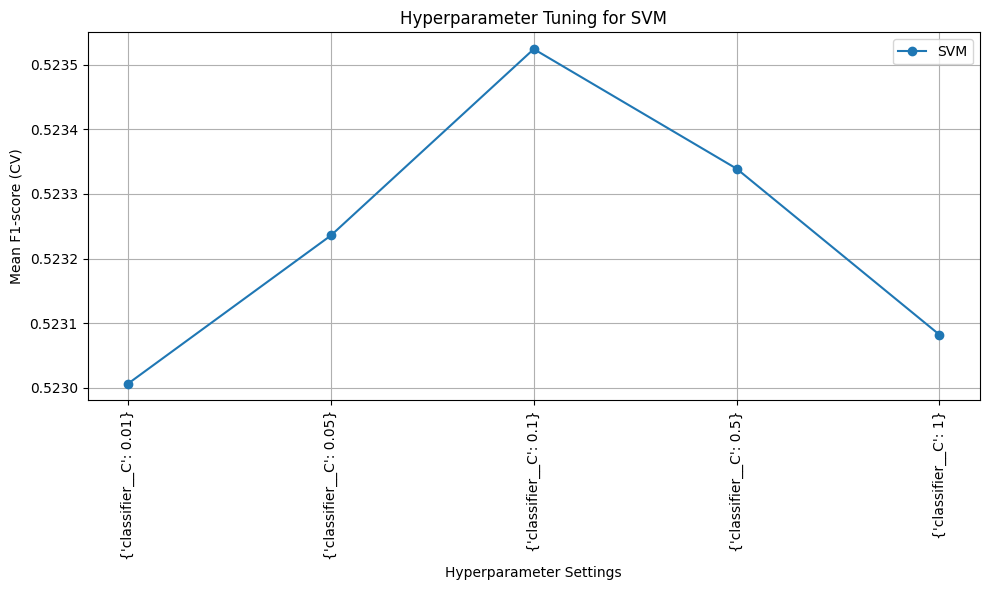

<ipython-input-73-f3ac5152e0fb>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


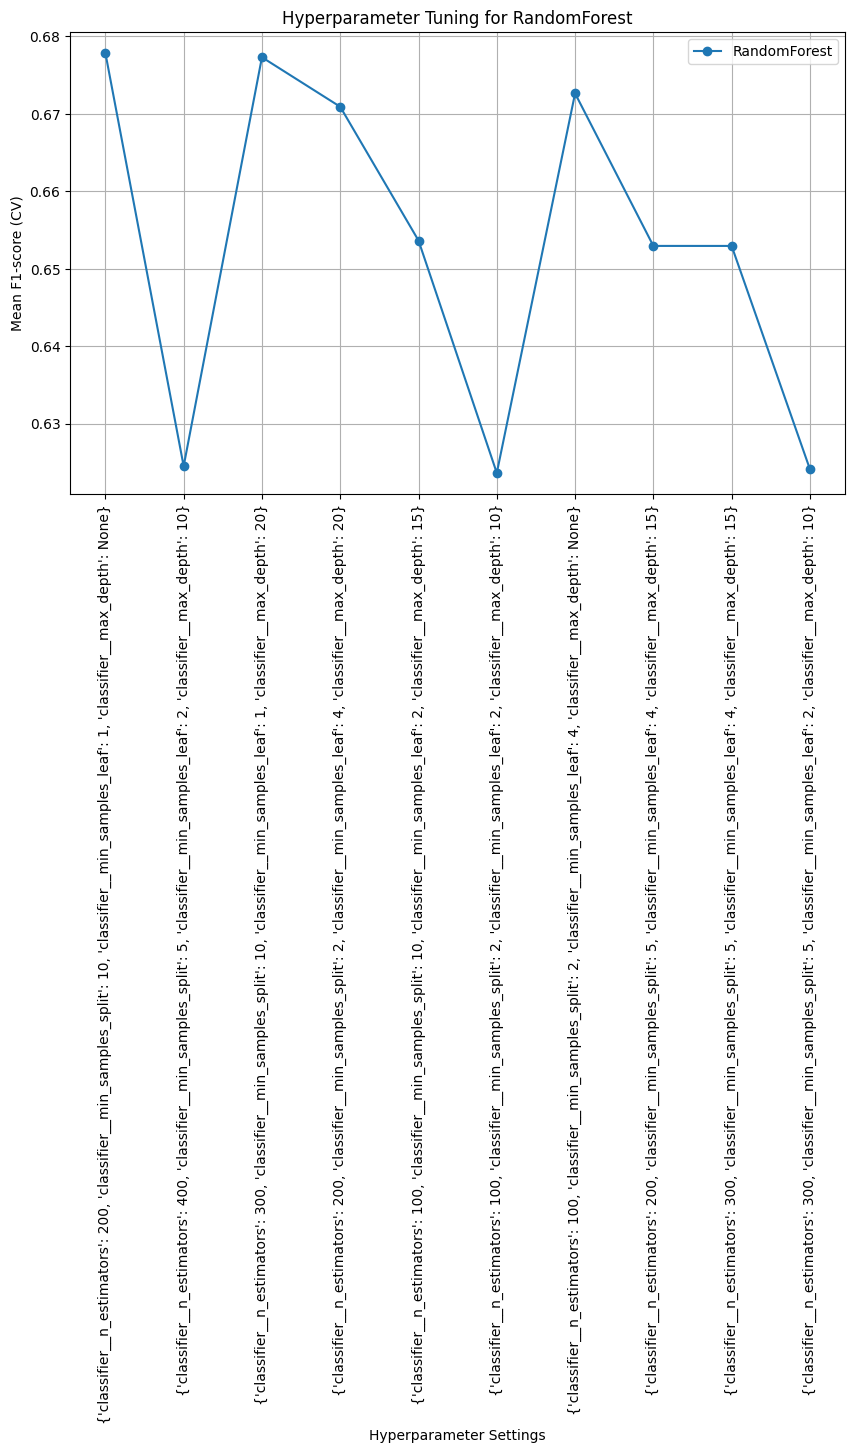

<ipython-input-73-f3ac5152e0fb>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


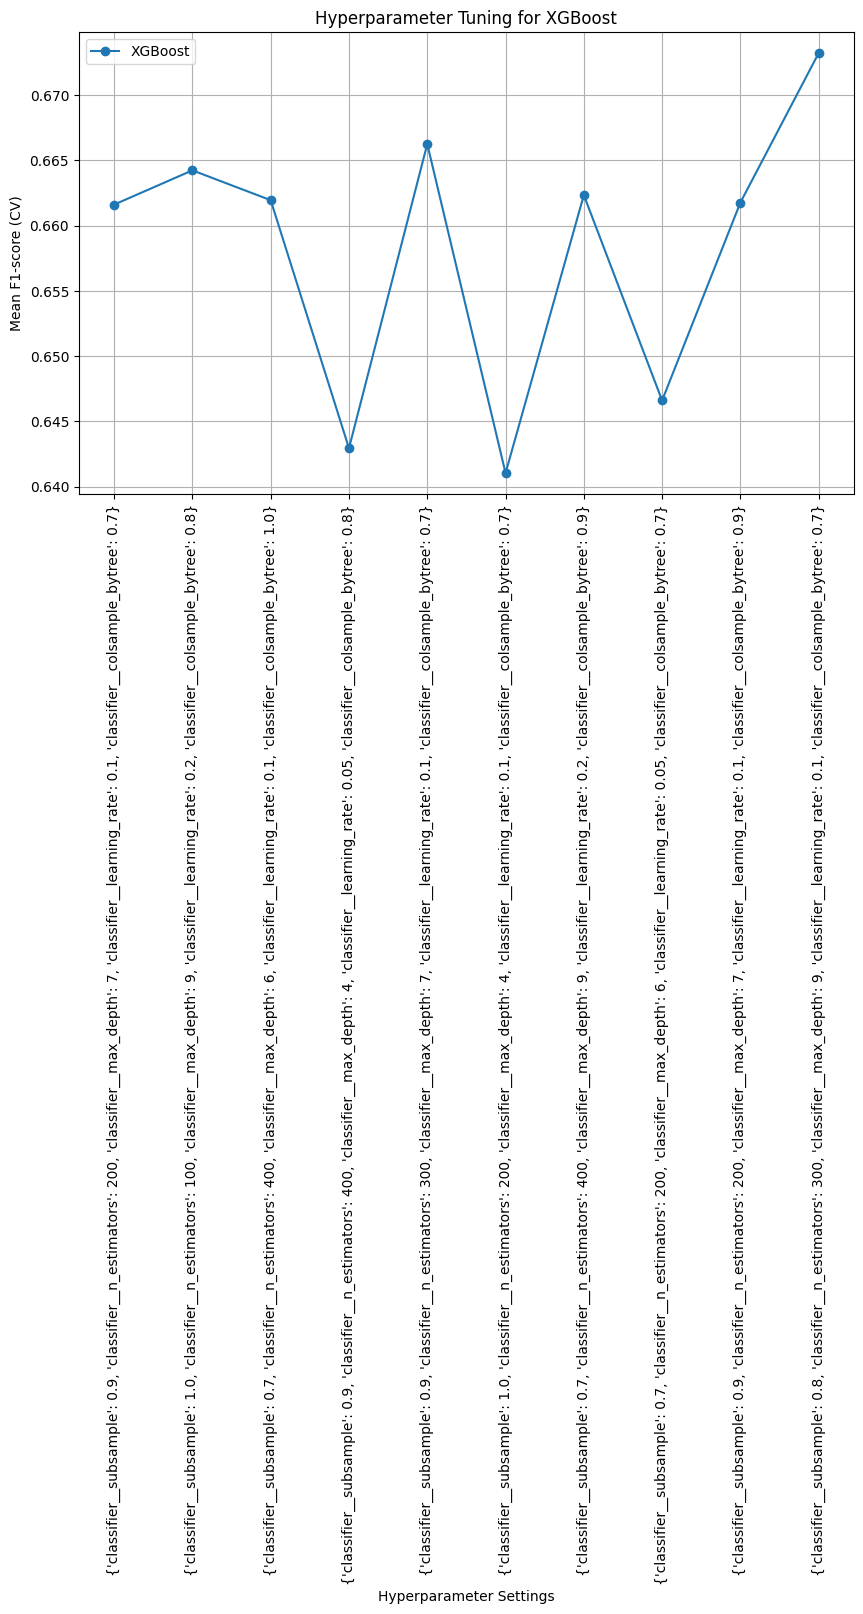

In [ ]:
import matplotlib.pyplot as plt

for model_name, grid in grid_results.items():
    results = grid.cv_results_
    params = results['params']
    mean_scores = results['mean_test_score']
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(params)), mean_scores, marker='o', linestyle='-', label=f'{model_name}')
    plt.xticks(range(len(params)), labels=[str(p) for p in params], rotation=90)
    plt.xlabel('Hyperparameter Settings')
    plt.ylabel('Mean F1-score (CV)')
    plt.title(f'Hyperparameter Tuning for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [87]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_test_flat = y_test['readmitted'].ravel()

summary_table = []

for model_name, grid in grid_results.items():
    # Cross-validation results
    cv_mean = grid.cv_results_['mean_test_score'][grid.best_index_]
    cv_std = grid.cv_results_['std_test_score'][grid.best_index_]

    # Test results.
    y_pred_test = grid.predict(X_test)
    test_accuracy = accuracy_score(y_test_flat, y_pred_test)
    test_precision = precision_score(y_test_flat, y_pred_test)
    test_recall = recall_score(y_test_flat, y_pred_test)
    test_f1 = f1_score(y_test_flat, y_pred_test)

    summary_table.append({
        'Model': model_name,
        'CV Mean F1-score': f"{cv_mean:.4f} ± {cv_std:.4f}",
        'Test Accuracy': f"{test_accuracy:.4f}",
        'Test Precision': f"{test_precision:.4f}",
        'Test Recall': f"{test_recall:.4f}",
        'Test F1-score': f"{test_f1:.4f}"
    })

performance_df = pd.DataFrame(summary_table)
display(performance_df)

,Model,CV Mean F1-score,Test Accuracy,Test Precision,Test Recall,Test F1-score
0,SVM,0.5235 ± 0.0090,0.6129,0.6231,0.4132,0.4969
1,RandomForest,0.6779 ± 0.0073,0.6362,0.6164,0.5653,0.5898
2,XGBoost,0.6732 ± 0.0046,0.6184,0.5890,0.5791,0.5840


## Task 4


Extracting feature importance for SVM...


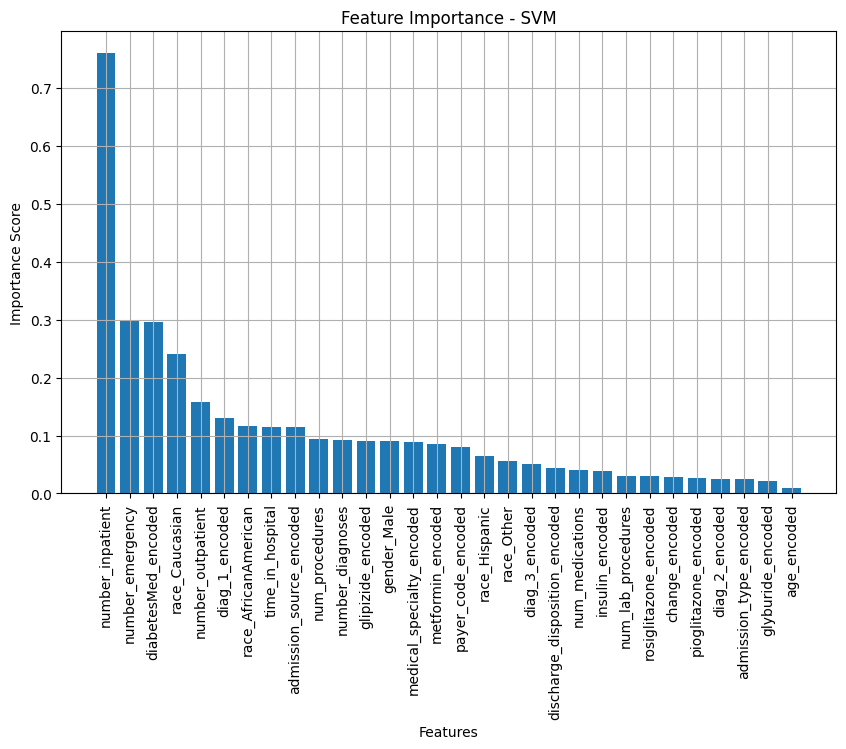


Extracting feature importance for RandomForest...


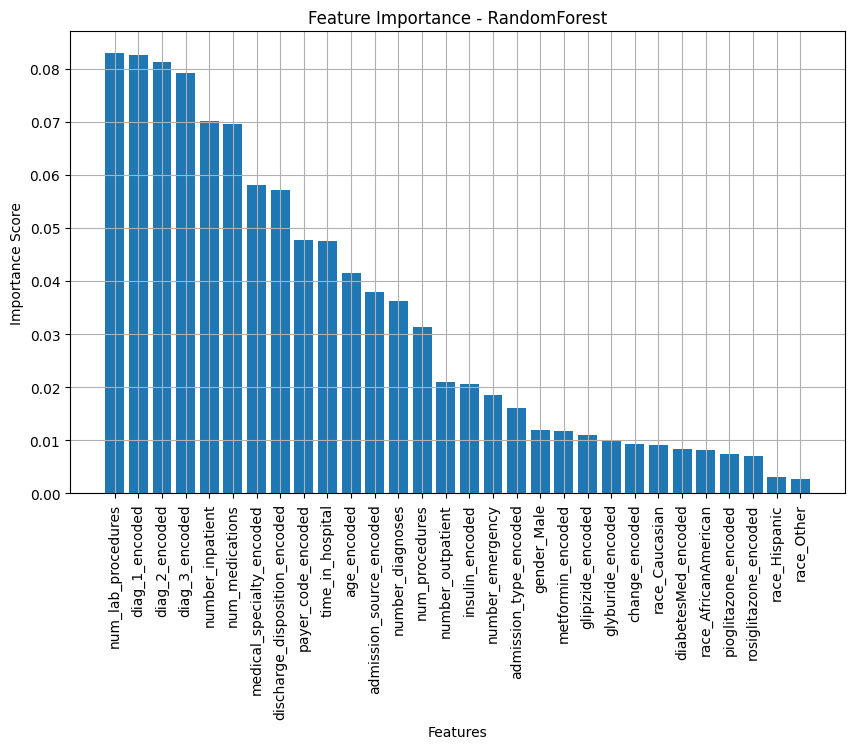


Extracting feature importance for XGBoost...


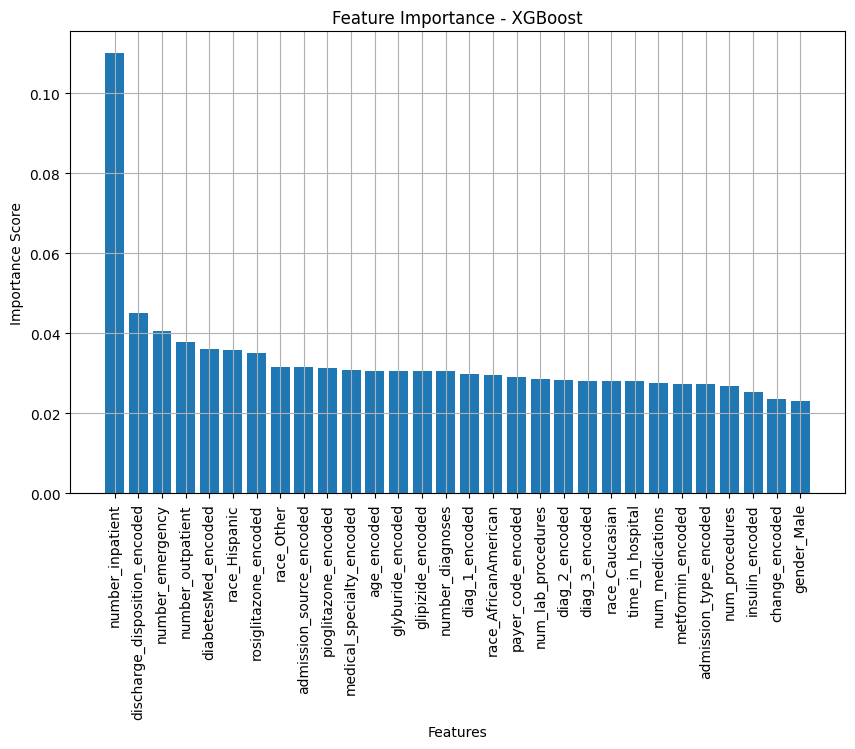

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure feature names exist
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X_train.shape[1])]

# Dictionary to store feature importance for each model
feature_importance_dict = {}

# Extract feature importance for each model
for model_name, grid_search in grid_results.items():
    print(f"\nExtracting feature importance for {model_name}...")

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_.named_steps['classifier']

    if model_name == "SVM":
        # Ensure coef_ exists (only for linear SVM)
        if hasattr(best_model, "coef_"):
            importance = np.abs(best_model.coef_).flatten()
        else:
            print(f" SVM model has no `coef_` attribute! Skipping...")
            continue  # Skip if feature importance isn't available

    elif model_name in ["RandomForest", "XGBoost"]:
        # Feature importance for tree-based models
        if hasattr(best_model, "feature_importances_"):
            importance = best_model.feature_importances_
        else:
            print(f" {model_name} model has no `feature_importances_` attribute! Skipping...")
            continue

    else:
        print(f" Feature importance not implemented for {model_name}. Skipping...")
        continue  # Ignore models without feature importance

    # Store importance scores
    feature_importance_dict[model_name] = importance

    # Sort features by importance (descending order)
    sorted_idx = np.argsort(importance)[::-1]

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance[sorted_idx], align="center")
    plt.xticks(range(len(importance)), np.array(feature_names)[sorted_idx], rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.title(f"Feature Importance - {model_name}")
    plt.grid(True)
    plt.show()

# 4.2 - Create a summary table of feature rankings
feature_rankings = []
for model_name, importance in feature_importance_dict.items():
    sorted_idx = np.argsort(importance)[::-1]
    ranked_features = np.array(feature_names)[sorted_idx]

    feature_rankings.append(pd.DataFrame({
        "Model": model_name,
        "Feature Rank": range(1, len(feature_names) + 1),
        "Feature Name": ranked_features,
        "Importance Score": importance[sorted_idx]
    }))

# Concatenate results into a single DataFrame
feature_ranking_df = pd.concat(feature_rankings, ignore_index=True)

# Display feature importance rankings
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Feature Importance Rankings", dataframe=feature_ranking_df)


In [ ]:
# Display the table
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Feature Importance Rankings", dataframe=feature_ranking_df)
from IPython.display import display

# Display the feature importance ranking table
print("📊 Feature Importance Rankings:")
display(feature_ranking_df)

print("✅ Feature importance plots generated for all models.")
print("✅ A table ranking features based on importance across models has been created.")



📊 Feature Importance Rankings:


,Model,Feature Rank,Feature Name,Importance Score
0,SVM,1,number_inpatient,0.759598
1,SVM,2,number_emergency,0.299691
2,SVM,3,diabetesMed_encoded,0.295400
3,SVM,4,race_Caucasian,0.241076
4,SVM,5,number_outpatient,0.158515
...,...,...,...,...
85,XGBoost,26,admission_type_encoded,0.027402
86,XGBoost,27,num_procedures,0.026967
87,XGBoost,28,insulin_encoded,0.025338
88,XGBoost,29,change_encoded,0.023629


✅ Feature importance plots generated for all models.
✅ A table ranking features based on importance across models has been created.


In [79]:
# Dictionary to store sorted feature rankings for each model
sorted_feature_lists = {}

# Iterate through stored feature importances
for model_name, importance in feature_importance_dict.items():
    # Get indices of features sorted in descending order (most important first)
    sorted_idx = np.argsort(importance)[::-1]  # Change order to descending

    # Get feature names and importance values in descending order
    ranked_features = np.array(feature_names)[sorted_idx]
    ranked_importance = importance[sorted_idx]

    # Store in dictionary
    sorted_feature_lists[model_name] = list(zip(ranked_features, ranked_importance))

# # Print sorted feature lists for each model
# for model_name, feature_list in sorted_feature_lists.items():
#     print(f"\n🔹 {model_name} Feature Importance (Descending Order):")
#     for feature, importance in feature_list:
#         print(f"{feature}: {importance:.6f}")

# If you want to print the full dictionary at once:
print(sorted_feature_lists)


{'SVM': [('number_inpatient', 0.7595975773486359), ('number_emergency', 0.2996905823903546), ('diabetesMed_encoded', 0.2953999228654993), ('race_Caucasian', 0.24107639800644165), ('number_outpatient', 0.1585146406818847), ('diag_1_encoded', 0.130257633450805), ('race_AfricanAmerican', 0.11733499046659546), ('time_in_hospital', 0.11539465360781076), ('admission_source_encoded', 0.11504987685971724), ('num_procedures', 0.09424577012825752), ('number_diagnoses', 0.09184005003540818), ('glipizide_encoded', 0.09142191037075875), ('gender_Male', 0.08989401968420907), ('medical_specialty_encoded', 0.08868237964568237), ('metformin_encoded', 0.08584810866132653), ('payer_code_encoded', 0.08071838295682099), ('race_Hispanic', 0.065053978442414), ('race_Other', 0.05645389110942656), ('diag_3_encoded', 0.05007776851919221), ('discharge_disposition_encoded', 0.04364552514617959), ('num_medications', 0.04080666809271716), ('insulin_encoded', 0.039406915149398536), ('num_lab_procedures', 0.030896605

## Task 5

In [80]:
# Dictionary to store sorted feature rankings for each model
sorted_feature_lists = {}

# Set the number of top features to keep (you can change these values)
top_features_per_model = {
    "SVM": 18,           # Select top 15 features for SVM
    "RandomForest": 25,  # Select top 20 features for RandomForest
    "XGBoost": 28        # Select top 25 features for XGBoost
}

# Iterate through stored feature importances
filtered_feature_lists = {}

for model_name, importance in feature_importance_dict.items():
    # Get indices of features sorted in descending order (most important first)
    sorted_idx = np.argsort(importance)[::-1]

    # Get feature names and importance values in descending order
    ranked_features = np.array(feature_names)[sorted_idx]
    ranked_importance = importance[sorted_idx]

    # Store full sorted list
    sorted_feature_lists[model_name] = list(zip(ranked_features, ranked_importance))

    # Select only the top N features based on the predefined dictionary
    top_n = top_features_per_model.get(model_name, len(ranked_features))  # Default to all if not specified
    filtered_feature_lists[model_name] = list(zip(ranked_features[:top_n], ranked_importance[:top_n]))

# Print filtered feature lists for each model
for model_name, feature_list in filtered_feature_lists.items():
    print(f"\n🔹 {model_name} Top {len(feature_list)} Features (Descending Order):")
    for feature, importance in feature_list:
        print(f"{feature}: {importance:.6f}")

# If you want to print the full dictionary at once:
# print(filtered_feature_lists)



🔹 SVM Top 18 Features (Descending Order):
number_inpatient: 0.759598
number_emergency: 0.299691
diabetesMed_encoded: 0.295400
race_Caucasian: 0.241076
number_outpatient: 0.158515
diag_1_encoded: 0.130258
race_AfricanAmerican: 0.117335
time_in_hospital: 0.115395
admission_source_encoded: 0.115050
num_procedures: 0.094246
number_diagnoses: 0.091840
glipizide_encoded: 0.091422
gender_Male: 0.089894
medical_specialty_encoded: 0.088682
metformin_encoded: 0.085848
payer_code_encoded: 0.080718
race_Hispanic: 0.065054
race_Other: 0.056454

🔹 RandomForest Top 25 Features (Descending Order):
num_lab_procedures: 0.082871
diag_1_encoded: 0.082518
diag_2_encoded: 0.081333
diag_3_encoded: 0.079286
number_inpatient: 0.070246
num_medications: 0.069666
medical_specialty_encoded: 0.058139
discharge_disposition_encoded: 0.057235
payer_code_encoded: 0.047831
time_in_hospital: 0.047645
age_encoded: 0.041558
admission_source_encoded: 0.037867
number_diagnoses: 0.036201
num_procedures: 0.031262
number_outpa

In [81]:
import numpy as np

# Assuming 'importance' is the sorted feature importance array from RandomForest
cumulative_importance = np.cumsum(importance)  # Cumulative sum of feature importance
total_importance = np.sum(importance)

# Find the number of features needed to reach 95% importance
num_features_95 = np.argmax(cumulative_importance >= 0.95 * total_importance) + 1

print(f"Number of features to retain for 95% cumulative importance: {num_features_95}")

# Optional: Keep only features above a certain threshold (e.g., 0.01)
selected_features_threshold = np.sum(importance >= 0.01)
print(f"Number of features with importance >= 0.01: {selected_features_threshold}")


Number of features to retain for 95% cumulative importance: 1
Number of features with importance >= 0.01: 1


In [82]:
# Choose the model for feature selection (change to "RandomForest" or "XGBoost" if needed)
selected_model = "RandomForest"

# Get the selected top features from the filtered list
selected_features = [feature for feature, _ in filtered_feature_lists[selected_model]]

# Keep only the selected features in X_train and X_test.
X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

print(f"✅ X_train and X_test now only contain the top {len(selected_features)} features from {selected_model}.")
print(f"Remaining Features: {list(X_test_filtered.columns)}")


✅ X_train and X_test now only contain the top 25 features from RandomForest.
Remaining Features: ['num_lab_procedures', 'diag_1_encoded', 'diag_2_encoded', 'diag_3_encoded', 'number_inpatient', 'num_medications', 'medical_specialty_encoded', 'discharge_disposition_encoded', 'payer_code_encoded', 'time_in_hospital', 'age_encoded', 'admission_source_encoded', 'number_diagnoses', 'num_procedures', 'number_outpatient', 'insulin_encoded', 'number_emergency', 'admission_type_encoded', 'gender_Male', 'metformin_encoded', 'glipizide_encoded', 'glyburide_encoded', 'change_encoded', 'race_Caucasian', 'diabetesMed_encoded']


In [83]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
# X_train_filtered, X_test_filtered

y_train_flat = y_train['readmitted'].values.ravel()
y_test_flat = y_test['readmitted'].values.ravel()

# Define the best RandomForest model with optimal parameters
# best_rf = RandomForestClassifier(n_estimators=300, min_samples_split=10,
#                                  min_samples_leaf=1, max_depth=20, random_state=42)


best_rf = RandomForestClassifier(n_estimators=200, min_samples_split=10,
                                 min_samples_leaf=1, max_depth=None, random_state=42)


# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation directly on the filtered X_train
cv_f1_scores = cross_val_score(best_rf, X_train_filtered, y_train_flat, cv=cv_strategy, scoring='f1')

# Train model on full training data (NO feature selection step needed)
best_rf.fit(X_train_filtered, y_train_flat)

# Evaluate on test set
y_pred = best_rf.predict(X_test_filtered)

# Compute performance metrics
test_accuracy = accuracy_score(y_test_flat, y_pred)
test_precision = precision_score(y_test_flat, y_pred)
test_recall = recall_score(y_test_flat, y_pred)
test_f1 = f1_score(y_test_flat, y_pred)

# Compute standard deviation for cross-validation
cv_f1_mean = np.mean(cv_f1_scores)
cv_f1_std = np.std(cv_f1_scores)

# Store results
results_dict = {
    "Metric": ["CV Mean F1-score", "Test Accuracy", "Test Precision", "Test Recall", "Test F1-score"],
    "Before Feature Selection": ["0.6779 ± 0.0073", "0.6362", "0.6164", "0.5653", "0.5898"],
    "After Feature Selection": [f"{cv_f1_mean:.4f} ± {cv_f1_std:.4f}",
                                f"{test_accuracy:.4f}",
                                f"{test_precision:.4f}",
                                f"{test_recall:.4f}",
                                f"{test_f1:.4f}"]
}

# Convert results_dict into a DataFrame
results_df = pd.DataFrame(results_dict)

# Display DataFrame in a Jupyter Notebook
display(results_df)

# RandomForest	0.6779 ± 0.0073	0.6362	0.6164	0.5653	0.5898

,Metric,Before Feature Selection,After Feature Selection
0,CV Mean F1-score,0.6779 ± 0.0073,0.6767 ± 0.0065
1,Test Accuracy,0.6362,0.6392
2,Test Precision,0.6164,0.6220
3,Test Recall,0.5653,0.5611
4,Test F1-score,0.5898,0.5900


In [84]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select exactly 25 best features using ANOVA F-test
feature_selector = SelectKBest(f_classif, k=25)
X_selected = feature_selector.fit_transform(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[feature_selector.get_support()]

print("🔍 Selected Features (Using SelectKBest):")
print(selected_features)


🔍 Selected Features (Using SelectKBest):
Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'payer_code_encoded',
       'admission_source_encoded', 'discharge_disposition_encoded',
       'diag_1_encoded', 'diag_3_encoded', 'admission_type_encoded',
       'medical_specialty_encoded', 'race_AfricanAmerican', 'race_Caucasian',
       'gender_Male', 'age_encoded', 'insulin_encoded', 'glipizide_encoded',
       'metformin_encoded', 'pioglitazone_encoded', 'change_encoded',
       'diabetesMed_encoded'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
